<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/main/IDP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsically disordered proteins in thermophilic bacteria

In this notebook we go through IDR prediction of various protein datasets and compare the IDR content of these datasets.

https://omabrowser.org/oma/genomePW/

https://github.com/dessimozlab/pyham

In [2]:
# !git init

# %cd /content/IDP_analysis/

# !git add .

# !git config --global user.email "alibek.kruglikov11@gmail.com"
# !git config --global user.name "alibekk93"

# !git commit -m "Message"

# !git push https://<token>@github.com/alibekk93/IDP_analysis.git

Initialized empty Git repository in /content/.git/
/content/IDP_analysis
[main 4a6a917] Added MH files
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 datafiles/MH_disorder_iupred3.pkl
 create mode 100644 datafiles/MH_disorder_pondr.pkl
 create mode 100644 datafiles/MH_proteome.pkl
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 22.93 MiB | 6.56 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To https://github.com/alibekk93/IDP_analysis.git
   ea8be97..4a6a917  main -> main


## Setup

[Biopython](https://biopython.org/) package is used to read .fasta files and work with sequences. Other packages are used to process the data, connect with API services to predict IDR, download results, etc.

In [3]:
# copy repo to get available datafiles

!git clone https://github.com/alibekk93/IDP_analysis.git

Cloning into 'IDP_analysis'...
remote: Enumerating objects: 670, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 670 (delta 137), reused 142 (delta 53), pack-reused 385
Receiving objects: 100% (670/670), 249.18 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (248/248), done.
Checking out files: 100% (58/58), done.


In [4]:
#@title # Do you already have the disorder scores?

#@markdown Many of the packages are only required if
#@markdown you have to calculate the disorder scores.
#@markdown If you already have the scores, you should
#@markdown tick the box below, it will save time.

scores_calculated = True #@param {type: 'boolean'}

if scores_calculated == False:
  # connecting with API
  import urllib.request
  import json

  # install chromium, its driver, and selenium, set options
  !apt update
  !apt install chromium-chromedriver
  !pip install selenium
  from selenium import webdriver
  from selenium.webdriver.common.keys import Keys
  from selenium.webdriver.common.by import By
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')

# Biopython
!pip install BIO
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat.MatrixInfo import blosum62
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParamData import gravy_scales

# files uploading / downloading
from google.colab import files
import pickle
from io import StringIO

# statistics
!pip install --upgrade scipy
from scipy.stats import mannwhitneyu, chisquare, pearsonr, ttest_ind, ttest_rel, wilcoxon
from sklearn.preprocessing import MinMaxScaler

# other packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
tqdm.pandas()

# install ClustalW
!sudo apt-get update
!sudo apt-get install clustalw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 9.4 MB/s 
     |████████████████████████████████| 2.3 MB 48.4 MB/s 


/usr/local/lib/python3.7/dist-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,540 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main am

In [5]:
models = ['VLXT', 'VL3', 'VSL2', 'iupred3']

## Functions

In [6]:
def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.
  
  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

In [7]:
def try_retrieve_url(url: str, filename: str):
  """A simple try / except pattern for urllib.request
  """

  try:
    return urllib.request.urlretrieve(url, filename)
  except:
    return np.nan

In [8]:
def calculate_iupred(proteinID_list: list, score_only: bool=True) -> list:
  """Calculate protein IDR profile using IUPred3 REST API

  Creates URL based on protein UniProt accession numbers
  (from a list). Each IDR profile is saved as a JSON file
  and put into a list. The JSON files are then unpacked,
  either all data or only IUPred3 score are saved.

  Parameters
  ----------
  proteinID_list : list
    a list of protein accessions for which to predict IDR
  score_only : bool (default=True)
    whether the return should only contain IUPRed3 score.
    Other data are AA sequence, and a binary disorder
    prediction.

  Returns
  -------
  list
    a list of either IUPred3 scores or of all data from
    each JSON as a dictionary.

  """

  # make a list of URLs
  iupredURL_list = ['http://iupred3.elte.hu/iupred3/' + proteinID + '.json' \
                    for proteinID in proteinID_list]

  # download JSON files
  print('Retrieving disorder values from server...')
  protein_files = [try_retrieve_url(iupredURL, proteinID  + '.json')\
                   for iupredURL, proteinID in zip(tqdm(iupredURL_list),\
                                                        proteinID_list)]
  
  # empty list for unpacked JSON data
  proteins = []
  
  # populate the empty list
  print('Unpacking json files...')
  for proteinID in tqdm(proteinID_list):
    try:
      with open('/content/{}.json'.format(proteinID), 'r') as f:
        d = json.load(f)
        # check if only scores need to be saved
        if score_only == True:
          d = d['iupred2']
    except:
      d = np.nan
    proteins.append(d)
  
  return proteins

In [9]:
def read_pickle_file(file_name: str):
  """A simple function to read pickle files

  Parameters
  ----------
  file_name : srt
    location of the pickle file
  
  Returns
  -------
  any format, but best with pd.DataFrames or lists
  
  """

  print(file_name + ' loading...')
  with open(file_name, 'rb') as f:
    result = pickle.load(f)
  print(file_name + ' loaded!')
  return result

In [10]:
def binary_disorder(disorder_list: list, threshold: float=0.5) -> list:
  """Returns a list of binary values for disordered
  residues given a threshold

  Parameters
  ----------
  disorder_list : list
    a list of disorder values
  threshold : float
    a binary threshold, 0.5 by default. Disorder score
    above the threshold means that the residue is
    considered to be disordered
  
  Returns
  -------
  list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  """

  return [1 if dis > threshold else 0 for dis in disorder_list]

In [11]:
def find_longest_binary_IDR(binary_disorder_list: list) -> int:
  """Finds the longest stretch of binary IDR for a
  given protein

  Parameters
  ----------
  binary_disorder_list : list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  Returns
  -------
  int
    a number of disordered residues in the longest
    IDR
  
  """

  # set max IDR length as zero
  max_IDR_len = 0

  # set current IDR length as zero
  current_IDR_len = 0
  # iterate though each residue
  for disorder in binary_disorder_list:
    if disorder == 1:
      # increase current IDR length if disordered
      current_IDR_len += 1
    else:
      # not part of IDR, save current length if max or continue
      if current_IDR_len > max_IDR_len:
        max_IDR_len = current_IDR_len
      current_IDR_len = 0

  return max_IDR_len

In [12]:
def get_pondr_calculations(protein_ID: str, sequence: str, return_df: bool=True):
  """Uses Selenium to scrape PONDR disorder
  calculations for a given protein

  Parameters
  ----------
  protein_ID : str
    protein ID or name. Required by PONDR,
    but has no effect on result
  sequence : str
    AA sequence of the protein
  return_df : bool
    whether return should be a DataFrame
    (True) or a tuple of lists (False). True
    by default
  
  Returns:
  --------
  DataFrame or tuple with lists

  """

  # set up web driver to get data from pondr.com
  wd = webdriver.Chrome(options=options)
  wd.get('http://www.pondr.com/')
  # set options and submit
  wd.find_element(By.NAME, 'ProteinName').send_keys(protein_ID)
  wd.find_element(By.NAME, 'Sequence').send_keys(sequence)
  wd.find_element(By.NAME, 'VL3').click()
  wd.find_element(By.NAME, 'VSL2').click()
  wd.find_element(By.NAME, 'wcwraw').click()
  wd.find_element(By.NAME, 'submit_result').click()
  # paste the raw results table to a DataFrame
  try:
    table = wd.find_elements(By.TAG_NAME, 'pre')[-1]
    table_text = table.text
    disorder_df = pd.read_csv(StringIO(table_text.replace('  ', ' ')), sep=' ')[['VLXT', 'VL3', 'VSL2']]
  except:
    disorder_df = pd.DataFrame(columns=['VLXT', 'VL3', 'VSL2'])
  if return_df == True:
    return disorder_df
  else:
    return [*disorder_df['VLXT']], [*disorder_df['VL3']], [*disorder_df['VSL2']]

In [13]:
def fix_neg_inf(df: pd.DataFrame, replacement=np.nan) -> pd.DataFrame:
  """Replaces -inf values in a given dataframe

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe with -inf to be replaced
  replacement
    The value to replace -inf with. Default
    is np.nan
  
  Returns:
  --------
  pd.DataFrame

  """

  df_new = df.copy()
  df_new[df.astype(float) < 0] = replacement
  return df_new

In [14]:
def align_seqs(seqs: list, ids: list, gap_ins_pen: float=-1.0,
               gap_ext_pen: float=-0.5):
  """Multiple sequence alignment using ClustalW

  Parameters
  ----------
  seqs : list
    A list of sequences to be aligned (as str)
  ids : list
    A list of sequence IDs (as str)
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    -1.0 by default
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    -0.5 by default
  
  Returns
  -------
  Alignment object

  """

  # create seq records
  records = [SeqRecord(Seq(seq), id) for seq, id in zip(seqs, ids)]
  # save records as fasta
  with open('unaligned.fas', 'w') as handle:
    SeqIO.write(records, handle, 'fasta')
  # align using ClustalW
  cline = ClustalwCommandline(infile='unaligned.fas', outfile='aligned.fas',
                            gapext=gap_ext_pen, gapopen=gap_ins_pen,
                            type='PROTEIN', outorder='INPUT',
                            output='FASTA')
  cline()
  # read the output file
  align = AlignIO.read('aligned.fas', 'fasta')
  return align

In [15]:
def plot_IDR_profile(disorder_values: list, seqs: list, labels: list,
                     colors: list, names: list=None, mav: int=1,
                     scale_mav=False, gap_ins_pen: float=-1.0,
                     gap_ext_pen: float=-0.5, savefig=False):
  """Plots an aligned IDR profile for proteins given
  their disorders and sequences lists

  Parameters
  ----------
  disorder_values : list
    A list of disorder values to be plotted
  seqs : list
    A list of sequences to be aligned
  labels : list
    A list of labels for the plot legend
  names : list
    A list of titles to be plotted. Is not
    required, but makes plot better
  mav : int
    Moving average value. 1 by default,
    which plots original values
  scale_mav : bool
    Whether mav should be scaled based on
    protein length. If True, original mav
    value would be multiplied by
    len(protein) / 500. False by default
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    Default penalty is -1
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    Default penalty is -0.5
  savefig : bool
    Whether the figure should be saved.
    False by default
  
  Returns:
  --------
  No return, makes a plot

  """

  # make the alignment
  aligned_disorders = []
  alignment = align_seqs(seqs, labels, gap_ins_pen=gap_ins_pen, gap_ext_pen=gap_ext_pen)
  for a, d in zip(alignment, disorder_values):
    seq_disorder_full = [*d.copy()]
    for i, residue in enumerate(a.seq):
      if residue == '-':
        seq_disorder_full.insert(i, np.nan)
    seq_disorder_full = pd.Series(seq_disorder_full).interpolate().tolist()
    aligned_disorders.append(seq_disorder_full)
  # plot values
  fig, ax = plt.subplots(figsize=(15, 8))
  # check for title
  if names != None:
    title = ''.join([n + ' : ' for n in names])
    fig.suptitle(title, fontsize=20)
  # Scale mav if needed
  if scale_mav == True:
    mav = int(np.round(mav * len(aligned_disorders[0]) / 500))
  # plot
  ax.set_ylim(0, 1)
  ax.set_xlabel('Position in sequence', fontsize=18)
  ax.set_ylabel('Predicted disorder', fontsize=18)
  ys = [np.convolve(ad, np.ones(mav)/mav) for ad in aligned_disorders]
  x = np.arange(0, len(ys[0]))
  for i, y in enumerate(ys):
    # cut extra mav values
    cut = int(mav / 2)
    # plot the values
    ax.plot(y[cut:len(y)-cut+1], c=colors[i], label='$\\it{}$'.format(labels[i]))
  # ax.fill_between(x, y1, y2, where = y1 > y2, facecolor ='red', alpha = 0.3)
  # ax.fill_between(x, y1, y2, where = y2 > y1, facecolor ='green', alpha = 0.3)
  ax.legend(loc='upper left')
  ax.axhline(0.5, ls='--', c='black')
  # check if needs to be saved
  if savefig == True:
    if names == None:
      raise ValueError('Sequence names not provided')
    fig.savefig(title + '.svg')

In [16]:
def get_charge_hydrophobicity(seq: str) -> tuple:
  """Calculates mean absolute charge and hydrophobicity
  
  Parameters
  ----------
  seq : str
    AA sequence to calculate values for
  
  Returns:
  --------
  tuple
    tuple with two float values:
    1) mean absolute charge
    2) mean hydrophobicity (scaled 0-1)

  """

  # calculate mean absolute charge
  prot_analysis = ProteinAnalysis(seq)
  mean_abs_charge = abs(prot_analysis.charge_at_pH(7)) / prot_analysis.length

  # get Kyle-Doolitle scale
  KyteDoolitle = gravy_scales.get('KyteDoolitle', -1)
  KyteDoolitle['X'] = 0
  KyteDoolitle['U'] = 0
  # normalize scale to 0-1 range
  scaler = MinMaxScaler()
  KD_norm = {k:v[0] for k, v in zip(KyteDoolitle.keys(), scaler.fit_transform(np.array([*KyteDoolitle.values()]).reshape(-1, 1)))}
  # calculate mean hydrophobicity
  hydrophobicity_sum = sum(KD_norm[aa] for aa in seq)
  mean_hydrophobicity = hydrophobicity_sum / prot_analysis.length
  
  return mean_abs_charge, mean_hydrophobicity

In [17]:
def drop_unavailable(proteome: pd.DataFrame, reset_index: bool=True) -> pd.DataFrame:
  """Drop rows if not all models are available

  """

  mask = [proteome.disorder.iloc[n].shape[1]==4 for n in range(len(proteome))]
  proteome = proteome[mask]
  if reset_index == True:
    proteome.reset_index(inplace=True, drop=True)
  return proteome

## Obtaining disorder predictions for *E. coli* and *T. thermophilus* proteins

We can start by importing the protein sequences

In [18]:
# read two .fasta files
EC_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/EscherichiaColiK12_allProteins.fasta')
TT_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/ThermusThermophilusHB8_allProteins.fasta')
BS_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/BacillusSubtilis168_allProteins.fasta')
MT_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/MethanothermobacterThermautotrophicusATCC29096.fasta')
MH_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/MarinithermusHydrothermalisDSM14884.fasta')
TM_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/ThermaerobacterMarianensisATCC700841.fasta')

# filter out short sequences (under 20 AA)
# short sequences do not get processed by IDR predictors
EC_proteome = EC_proteome_fasta[EC_proteome_fasta.Length > 19]
TT_proteome = TT_proteome_fasta[TT_proteome_fasta.Length > 19]
BS_proteome = BS_proteome_fasta[BS_proteome_fasta.Length > 19]
MT_proteome = MT_proteome_fasta[MT_proteome_fasta.Length > 19]
MH_proteome = MH_proteome_fasta[MH_proteome_fasta.Length > 19]
TM_proteome = TM_proteome_fasta[TM_proteome_fasta.Length > 19]

IUPred3 REST API works great for almost all proteins, however there are a couple exceptions.

First, IUPred3 only can predict IDR for proteins that are at least 20 AA long. For that reason we will filter out short proteins from our databases.

A more unfortunate issue is that in some rare cases the REST API does not return a JSON file due to server error 500. This happened with two protein accessions from our *E. coli* database (out of more than 4,000 accessions) - P76335 and P77650. The API still can provide results in text format, but those data cannot be downloaded as easily as JSON. To solve the issue, we obtain the results for the two accessions manually and concatenate the manual results with the automatic results in the same order as the data were in the original dataframe.

PONDR has no REST API, so we will use [Selenium](https://selenium-python.readthedocs.io/) to scrape the results. The protein IDs and sequences will be passed into corresponding HTML forms and raw results will be downloaded.

Our function processes the results into a dataframe with a column for each PONDR disorder predictor and a raw for each AA. Individual protein dataframes will be merged together with the IUPred3 disorder prediction values and saved into 'disorder' column of the proteome dataframes.

In [19]:
#@title # Which of TT files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

TT_proteome_filename = '/content/IDP_analysis/datafiles/TT_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

TT_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/TT_disorder_iupred3.pkl' #@param {type: 'string'}
TT_disorder_pondr_filename = '/content/IDP_analysis/datafiles/TT_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  TT_proteome = read_pickle_file(TT_proteome_filename)
  print('TT proteome file loaded!')
except:
  print('Complete TT proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    TT_disorder_iupred3 = read_pickle_file(TT_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(TT_disorder_iupred3)
    TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    TT_disorder_iupred3 = calculate_iupred(TT_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('TT_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(TT_disorder_iupred3, f)
    files.download('TT_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    TT_disorder_pondr = read_pickle_file(TT_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    TT_proteome['disorder_pondr'] = TT_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    TT_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(TT_proteome.ID, TT_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    TT_proteome['disorder_pondr'] = TT_disorder_pondr
    # save the PONDR disorder list for future
    with open('TT_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(TT_disorder_pondr, f)
    files.download('TT_disorder_iupred3.pkl')
  # combine the disorder values
  TT_proteome['disorder'] = TT_proteome.disorder_pondr.copy()
  for i in range(len(TT_proteome)):
    try:
      TT_proteome.disorder.iloc[i]['iupred3'] = TT_proteome.disorder_iupred3.iloc[i]
    except:
      TT_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':TT_proteome.disorder_iupred3.iloc[i]})
  TT_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  TT_proteome = drop_unavailable(TT_proteome)
  TT_proteome.to_pickle('TT_proteome.pkl')
  files.download('TT_proteome.pkl')

TT_proteome = drop_unavailable(TT_proteome)

/content/IDP_analysis/datafiles/TT_proteome.pkl loading...
/content/IDP_analysis/datafiles/TT_proteome.pkl loaded!
TT proteome file loaded!


With *E. coli* the process is more complex because of 500 error on IUPred3 server.

We have to save the data in parts, and two of these are manual.

In [20]:
from pandas.errors import EmptyDataError
#@title # Which of EC files do you have already?

#@markdown These files take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

EC_proteome_filename = '/content/IDP_analysis/datafiles/EC_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell
#@markdown or do the manual input

EC_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/EC_disorder_iupred3.pkl' #@param {type: 'string'}
EC_disorder_iupred3_1_filename = '' #@param {type: 'string'}
EC_disorder_iupred3_2_filename = '' #@param {type: 'string'}
EC_disorder_iupred3_3_filename = '' #@param {type: 'string'}

#@markdown Use these links to manually get the data:
#@markdown [P76335](https://iupred3.elte.hu/iupred3/P76335),
#@markdown [P77650](https://iupred3.elte.hu/iupred3/P77650)

#@markdown Copy and paste all the output below:

EC_disorder_iupred3_P76335 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.0832\t? 2\tK\t0.0644\t? 3\tR\t0.0489\t? 4\tK\t0.0382\t? 5\tV\t0.0330\t? 6\tL\t0.0328\t? 7\tA\t0.0366\t? 8\tM\t0.0429\t? 9\tL\t0.0500\t? 10\tV\t0.0565\t? 11\tP\t0.0611\t? 12\tA\t0.0590\t? 13\tL\t0.0469\t? 14\tL\t0.0477\t? 15\tV\t0.0547\t? 16\tA\t0.0679\t? 17\tG\t0.0894\t? 18\tA\t0.1120\t? 19\tA\t0.1313\t? 20\tN\t0.1513\t? 21\tA\t0.1734\t? 22\tA\t0.1863\t? 23\tE\t0.1956\t? 24\tV\t0.1966\t? 25\tY\t0.1941\t? 26\tN\t0.1948\t? 27\tK\t0.1950\t0 28\tD\t0.1883\t0 29\tG\t0.1796\t0 30\tN\t0.1633\t0 31\tK\t0.1362\t0 32\tL\t0.1187\t0 33\tD\t0.1035\t0 34\tL\t0.0984\t0 35\tY\t0.0961\t0 36\tG\t0.1031\t0 37\tK\t0.1061\t0 38\tV\t0.1117\t0 39\tV\t0.1248\t0 40\tG\t0.1329\t0 41\tL\t0.1496\t0 42\tH\t0.1528\t0 43\tY\t0.1620\t0 44\tF\t0.1740\t0 45\tS\t0.1923\t0 46\tD\t0.2007\t0 47\tD\t0.1953\t0 48\tS\t0.1785\t0 49\tG\t0.1715\t0 50\tS\t0.1805\t0 51\tD\t0.2025\t0 52\tG\t0.2295\t0 53\tD\t0.2611\t0 54\tM\t0.3026\t0 55\tS\t0.3309\t0 56\tY\t0.3543\t0 57\tA\t0.3642\t0 58\tR\t0.3538\t0 59\tI\t0.3315\t0 60\tG\t0.2807\t0 61\tF\t0.2450\t0 62\tK\t0.2060\t0 63\tG\t0.1945\t0 64\tE\t0.1879\t0 65\tT\t0.1832\t0 66\tQ\t0.1739\t0 67\tI\t0.1770\t0 68\tA\t0.1878\t0 69\tD\t0.2029\t0 70\tQ\t0.2060\t0 71\tF\t0.2075\t0 72\tT\t0.2074\t0 73\tG\t0.2137\t0 74\tY\t0.2241\t0 75\tG\t0.2351\t0 76\tQ\t0.2586\t0 77\tW\t0.2819\t0 78\tE\t0.2930\t0 79\tF\t0.3281\t0 80\tN\t0.3520\t0 81\tI\t0.3981\t0 82\tG\t0.4303\t0 83\tA\t0.4563\t0 84\tN\t0.4690\t0 85\tG\t0.4713\t0 86\tP\t0.4702\t0 87\tE\t0.4715\t0 88\tS\t0.4615\t0 89\tD\t0.4413\t0 90\tK\t0.4215\t0 91\tG\t0.4050\t0 92\tN\t0.3914\t0 93\tT\t0.3769\t0 94\tA\t0.3755\t0 95\tT\t0.3662\t0 96\tR\t0.3457\t0 97\tL\t0.3199\t0 98\tA\t0.2829\t0 99\tF\t0.2582\t0 100\tA\t0.2278\t0 101\tG\t0.2008\t0 102\tL\t0.1745\t0 103\tG\t0.1426\t0 104\tF\t0.1259\t0 105\tG\t0.1124\t0 106\tQ\t0.1046\t0 107\tN\t0.1025\t0 108\tG\t0.1049\t0 109\tT\t0.1021\t0 110\tF\t0.1106\t0 111\tD\t0.1218\t0 112\tY\t0.1412\t0 113\tG\t0.1482\t0 114\tR\t0.1590\t0 115\tN\t0.1557\t0 116\tY\t0.1507\t0 117\tG\t0.1429\t0 118\tV\t0.1330\t0 119\tV\t0.1259\t0 120\tY\t0.1266\t0 121\tD\t0.1269\t0 122\tV\t0.1391\t0 123\tE\t0.1410\t0 124\tA\t0.1443\t0 125\tW\t0.1492\t0 126\tT\t0.1642\t0 127\tD\t0.1804\t0 128\tM\t0.1907\t0 129\tL\t0.2025\t0 130\tP\t0.2243\t0 131\tE\t0.2361\t0 132\tF\t0.2445\t0 133\tG\t0.2523\t0 134\tG\t0.2716\t0 135\tD\t0.2782\t0 136\tT\t0.2868\t0 137\tY\t0.2953\t0 138\tA\t0.3092\t0 139\tG\t0.3261\t0 140\tA\t0.3343\t0 141\tD\t0.3288\t0 142\tN\t0.3234\t0 143\tF\t0.3114\t0 144\tM\t0.3078\t0 145\tN\t0.3138\t0 146\tG\t0.3088\t0 147\tR\t0.2939\t0 148\tA\t0.2858\t0 149\tN\t0.2792\t0 150\tG\t0.2649\t0 151\tV\t0.2526\t0 152\tA\t0.2519\t0 153\tT\t0.2427\t0 154\tY\t0.2357\t0 155\tR\t0.2314\t0 156\tN\t0.2288\t0 157\tN\t0.2260\t0 158\tG\t0.2187\t0 159\tF\t0.2006\t0 160\tF\t0.1626\t0 161\tG\t0.0927\t0' #@param {type: 'string'}
EC_disorder_iupred3_P77650 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.1753\t? 2\tK\t0.2426\t? 3\tE\t0.2756\t? 4\tK\t0.2882\t? 5\tT\t0.2902\t? 6\tI\t0.2881\t? 7\tI\t0.2854\t? 8\tI\t0.2835\t? 9\tV\t0.2820\t? 10\tG\t0.2800\t? 11\tG\t0.2703\t? 12\tG\t0.2513\t? 13\tQ\t0.2393\t? 14\tA\t0.2352\t? 15\tA\t0.2440\t? 16\tA\t0.2729\t? 17\tM\t0.3107\t? 18\tA\t0.3464\t? 19\tA\t0.3714\t? 20\tA\t0.3820\t? 21\tS\t0.3685\t? 22\tL\t0.3522\t? 23\tR\t0.3216\t? 24\tQ\t0.2998\t? 25\tQ\t0.2742\t? 26\tG\t0.2561\t? 27\tF\t0.2583\t? 28\tT\t0.2687\t? 29\tG\t0.2976\t? 30\tE\t0.3133\t? 31\tL\t0.3280\t? 32\tH\t0.3296\t? 33\tL\t0.3303\t? 34\tF\t0.3368\t? 35\tS\t0.3577\t? 36\tD\t0.3801\t? 37\tE\t0.3871\t? 38\tR\t0.3853\t? 39\tH\t0.3718\t? 40\tL\t0.3606\t? 41\tP\t0.3543\t? 42\tY\t0.3731\t? 43\tE\t0.3809\t? 44\tR\t0.4000\t? 45\tP\t0.4227\t? 46\tP\t0.4379\t? 47\tL\t0.4620\t? 48\tS\t0.4704\t? 49\tK\t0.4791\t? 50\tS\t0.4789\t? 51\tM\t0.4690\t? 52\tL\t0.4452\t? 53\tL\t0.4285\t? 54\tE\t0.4082\t? 55\tD\t0.3812\t? 56\tS\t0.3425\t? 57\tP\t0.3091\t? 58\tQ\t0.2822\t? 59\tL\t0.2733\t? 60\tQ\t0.2799\t? 61\tQ\t0.2950\t? 62\tV\t0.3126\t? 63\tL\t0.3365\t? 64\tP\t0.3579\t? 65\tA\t0.3601\t? 66\tN\t0.3379\t? 67\tW\t0.3160\t? 68\tW\t0.2908\t? 69\tQ\t0.2711\t? 70\tE\t0.2526\t? 71\tN\t0.2339\t? 72\tN\t0.2177\t? 73\tV\t0.2216\t? 74\tH\t0.2312\t? 75\tL\t0.2703\t? 76\tH\t0.3107\t? 77\tS\t0.3462\t? 78\tG\t0.3643\t? 79\tV\t0.3765\t? 80\tT\t0.3608\t? 81\tI\t0.3558\t? 82\tK\t0.3441\t? 83\tT\t0.3360\t? 84\tL\t0.3198\t? 85\tG\t0.3035\t? 86\tR\t0.3009\t? 87\tD\t0.3162\t? 88\tT\t0.3438\t? 89\tR\t0.3643\t? 90\tE\t0.3650\t? 91\tL\t0.3497\t? 92\tV\t0.3216\t? 93\tL\t0.3007\t? 94\tT\t0.2743\t? 95\tN\t0.2511\t? 96\tG\t0.2085\t? 97\tE\t0.1710\t? 98\tS\t0.1334\t? 99\tW\t0.1212\t? 100\tH\t0.1226\t? 101\tW\t0.1522\t? 102\tD\t0.1740\t? 103\tQ\t0.1928\t? 104\tL\t0.2025\t? 105\tF\t0.1966\t? 106\tI\t0.1870\t? 107\tA\t0.1717\t? 108\tT\t0.1563\t? 109\tG\t0.1295\t? 110\tA\t0.1087\t? 111\tA\t0.1053\t? 112\tA\t0.1177\t? 113\tR\t0.1426\t? 114\tP\t0.1587\t? 115\tL\t0.1735\t? 116\tP\t0.1765\t? 117\tL\t0.1853\t? 118\tL\t0.1885\t? 119\tD\t0.2018\t? 120\tA\t0.2095\t? 121\tL\t0.2095\t? 122\tG\t0.2044\t? 123\tE\t0.2080\t? 124\tR\t0.2106\t? 125\tC\t0.2114\t? 126\tF\t0.2163\t? 127\tT\t0.2160\t? 128\tL\t0.2155\t? 129\tR\t0.2112\t? 130\tH\t0.2171\t? 131\tA\t0.2307\t? 132\tG\t0.2564\t? 133\tD\t0.2812\t? 134\tA\t0.3009\t? 135\tA\t0.3196\t? 136\tR\t0.3176\t? 137\tL\t0.3234\t? 138\tR\t0.3175\t? 139\tE\t0.2972\t? 140\tV\t0.2634\t? 141\tL\t0.2368\t? 142\tQ\t0.2124\t? 143\tP\t0.1916\t? 144\tE\t0.1702\t? 145\tR\t0.1590\t? 146\tS\t0.1519\t? 147\tV\t0.1419\t? 148\tV\t0.1363\t? 149\tI\t0.1281\t? 150\tI\t0.1298\t? 151\tG\t0.1318\t? 152\tA\t0.1362\t? 153\tG\t0.1284\t? 154\tT\t0.1187\t? 155\tI\t0.1224\t? 156\tG\t0.1250\t? 157\tL\t0.1441\t? 158\tE\t0.1523\t? 159\tL\t0.1656\t? 160\tA\t0.1727\t? 161\tA\t0.1835\t? 162\tS\t0.1826\t? 163\tA\t0.1745\t? 164\tT\t0.1611\t? 165\tQ\t0.1451\t? 166\tR\t0.1327\t? 167\tR\t0.1266\t? 168\tC\t0.1325\t? 169\tK\t0.1411\t? 170\tV\t0.1682\t? 171\tT\t0.1825\t? 172\tV\t0.1953\t? 173\tI\t0.2086\t? 174\tE\t0.2259\t? 175\tL\t0.2573\t? 176\tA\t0.2758\t? 177\tA\t0.2960\t? 178\tT\t0.2967\t? 179\tV\t0.2948\t? 180\tM\t0.2840\t? 181\tG\t0.2798\t? 182\tR\t0.2730\t? 183\tN\t0.2746\t? 184\tA\t0.2851\t? 185\tP\t0.3088\t? 186\tP\t0.3459\t? 187\tP\t0.3853\t? 188\tV\t0.4296\t? 189\tQ\t0.4526\t? 190\tR\t0.4537\t? 191\tY\t0.4289\t? 192\tL\t0.3898\t? 193\tL\t0.3432\t? 194\tQ\t0.2833\t? 195\tR\t0.2328\t? 196\tH\t0.1788\t? 197\tQ\t0.1353\t? 198\tQ\t0.1027\t? 199\tA\t0.0920\t? 200\tG\t0.0987\t? 201\tV\t0.1177\t? 202\tR\t0.1408\t? 203\tI\t0.1632\t? 204\tL\t0.1851\t? 205\tL\t0.2048\t? 206\tN\t0.2122\t? 207\tN\t0.2038\t? 208\tA\t0.1799\t? 209\tI\t0.1493\t? 210\tE\t0.1349\t? 211\tH\t0.1368\t? 212\tV\t0.1499\t? 213\tV\t0.1761\t? 214\tD\t0.2141\t? 215\tG\t0.2603\t? 216\tE\t0.3001\t? 217\tK\t0.3367\t? 218\tV\t0.3630\t? 219\tE\t0.3759\t? 220\tL\t0.3741\t? 221\tT\t0.3540\t? 222\tL\t0.3246\t? 223\tQ\t0.2900\t? 224\tS\t0.2570\t? 225\tG\t0.2175\t? 226\tE\t0.1667\t? 227\tT\t0.1216\t? 228\tL\t0.1015\t? 229\tQ\t0.1007\t? 230\tA\t0.1085\t? 231\tD\t0.1155\t? 232\tV\t0.1270\t? 233\tV\t0.1379\t? 234\tI\t0.1441\t? 235\tY\t0.1473\t? 236\tG\t0.1408\t? 237\tI\t0.1308\t? 238\tG\t0.1072\t? 239\tI\t0.0962\t? 240\tS\t0.0963\t? 241\tA\t0.1218\t? 242\tN\t0.1584\t? 243\tE\t0.1912\t? 244\tQ\t0.2142\t? 245\tL\t0.2450\t? 246\tA\t0.2783\t? 247\tR\t0.3087\t? 248\tE\t0.3335\t? 249\tA\t0.3398\t? 250\tN\t0.3244\t? 251\tL\t0.3028\t? 252\tD\t0.2852\t? 253\tT\t0.2811\t? 254\tA\t0.2837\t? 255\tN\t0.2837\t? 256\tG\t0.2711\t? 257\tI\t0.2537\t? 258\tV\t0.2327\t? 259\tI\t0.2269\t? 260\tD\t0.2189\t? 261\tE\t0.2048\t? 262\tA\t0.1694\t? 263\tC\t0.1438\t? 264\tR\t0.1294\t? 265\tT\t0.1271\t? 266\tC\t0.1290\t? 267\tD\t0.1309\t? 268\tP\t0.1407\t? 269\tA\t0.1451\t? 270\tI\t0.1458\t? 271\tF\t0.1642\t? 272\tA\t0.1836\t? 273\tG\t0.1958\t? 274\tG\t0.2028\t? 275\tD\t0.1942\t? 276\tV\t0.1820\t? 277\tA\t0.1752\t? 278\tI\t0.1826\t? 279\tT\t0.1909\t? 280\tR\t0.1914\t? 281\tL\t0.1971\t? 282\tD\t0.2084\t? 283\tN\t0.2398\t? 284\tG\t0.2642\t? 285\tA\t0.2878\t? 286\tL\t0.3212\t? 287\tH\t0.3455\t? 288\tR\t0.3590\t? 289\tC\t0.3732\t? 290\tE\t0.3789\t? 291\tS\t0.3847\t? 292\tW\t0.3705\t? 293\tE\t0.3513\t? 294\tN\t0.3221\t? 295\tA\t0.2889\t? 296\tN\t0.2728\t? 297\tN\t0.2639\t? 298\tQ\t0.2570\t? 299\tA\t0.2393\t? 300\tQ\t0.2207\t? 301\tI\t0.2187\t? 302\tA\t0.2146\t? 303\tA\t0.2124\t? 304\tA\t0.2044\t? 305\tA\t0.1882\t? 306\tM\t0.1720\t? 307\tL\t0.1548\t? 308\tG\t0.1342\t? 309\tL\t0.1226\t? 310\tP\t0.1021\t? 311\tL\t0.0932\t? 312\tP\t0.0844\t? 313\tL\t0.0877\t? 314\tL\t0.1041\t? 315\tP\t0.1301\t? 316\tP\t0.1528\t? 317\tP\t0.1536\t? 318\tW\t0.1476\t0 319\tF\t0.1425\t0 320\tW\t0.1421\t0 321\tS\t0.1482\t0 322\tD\t0.1525\t0 323\tQ\t0.1529\t0 324\tY\t0.1578\t0 325\tS\t0.1667\t0 326\tD\t0.1825\t0 327\tN\t0.1858\t0 328\tL\t0.1808\t0 329\tQ\t0.1706\t0 330\tF\t0.1620\t0 331\tI\t0.1579\t0 332\tG\t0.1611\t0 333\tD\t0.1788\t0 334\tM\t0.2020\t0 335\tR\t0.2315\t0 336\tG\t0.2634\t0 337\tD\t0.2980\t0 338\tD\t0.3269\t0 339\tW\t0.3438\t0 340\tL\t0.3431\t0 341\tC\t0.3339\t0 342\tR\t0.3155\t0 343\tG\t0.2963\t0 344\tN\t0.2740\t0 345\tP\t0.2410\t0 346\tE\t0.2130\t0 347\tT\t0.1912\t0 348\tQ\t0.1876\t0 349\tK\t0.1845\t0 350\tA\t0.1864\t0 351\tI\t0.1850\t0 352\tW\t0.1734\t0 353\tF\t0.1602\t0 354\tN\t0.1432\t0 355\tL\t0.1309\t0 356\tQ\t0.1038\t0 357\tN\t0.0838\t0 358\tG\t0.0619\t0 359\tV\t0.0506\t0 360\tL\t0.0588\t0 361\tI\t0.0920\t0 362\tG\t0.1259\t0 363\tA\t0.1534\t0 364\tV\t0.1682\t0 365\tT\t0.1704\t0 366\tL\t0.1666\t0 367\tN\t0.1639\t0 368\tQ\t0.1649\t0 369\tG\t0.1640\t0 370\tR\t0.1642\t0 371\tE\t0.1765\t0 372\tI\t0.2079\t0 373\tR\t0.2530\t0 374\tP\t0.2881\t0 375\tI\t0.3143\t0 376\tR\t0.3080\t0 377\tK\t0.2851\t0 378\tW\t0.2480\t0 379\tI\t0.2154\t0 380\tQ\t0.1891\t0 381\tS\t0.1632\t0 382\tG\t0.1348\t0 383\tK\t0.1156\t0 384\tT\t0.1021\t0 385\tF\t0.1026\t0 386\tD\t0.1136\t0 387\tA\t0.1214\t0 388\tK\t0.1147\t0 389\tL\t0.1033\t0 390\tL\t0.0903\t0 391\tI\t0.0829\t0 392\tD\t0.0779\t0 393\tE\t0.0716\t0 394\tN\t0.0632\t0 395\tI\t0.0523\t0 396\tA\t0.0397\t0 397\tL\t0.0274\t0 398\tK\t0.0190\t0 399\tS\t0.0197\t0 400\tL\t0.0374\t0' #@param {type: 'string'}


#@markdown 

EC_disorder_pondr_filename = '/content/IDP_analysis/datafiles/EC_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  EC_proteome = read_pickle_file(EC_proteome_filename)
  print('EC proteome file loaded!')
  EC_proteome = drop_unavailable(EC_proteome)
except:
  print('Complete EC proteome dataframe is not available, checking for individual predictor files...')
  # calcuate IUPred3 disorder in three separate runs unless available as pickle
  try:
    EC_disorder_iupred3 = read_pickle_file(EC_disorder_iupred3_filename)
    print('IUPred file loaded!')
  except:
    dis_fns = [EC_disorder_iupred3_1_filename, EC_disorder_iupred3_2_filename, EC_disorder_iupred3_3_filename]
    for i in range(3):
      if dis_fns[i] == '':
        print(dis_fns[i] + ' not available, loading from API...')
        if i == 0:
          EC_disorder_iupred3_1 = calculate_iupred(EC_proteome.ID.iloc[:2700])
          # save the disorder values
          with open('EC_disorder_iupred3_1.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_1, f)
          files.download('EC_disorder_iupred3_1.pkl')
        elif i == 1:
          EC_disorder_iupred3_2 = calculate_iupred(EC_proteome.ID.iloc[2701:3882])
          # save the disorder values
          with open('EC_disorder_iupred3_2.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_2, f)
          files.download('EC_disorder_iupred3_2.pkl')
        elif i == 2:
          EC_disorder_iupred3_3 = calculate_iupred(EC_proteome.ID.iloc[3883:])
          # save the disorder values
          with open('EC_disorder_iupred3_3.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_3, f)
          files.download('EC_disorder_iupred3_3.pkl')
      else:
        print(dis_fns[i] + ' available, loading...')
        if i == 0:
          EC_disorder_iupred3_1 = read_pickle_file(dis_fns[i])
        elif i == 1:
          EC_disorder_iupred3_2 = read_pickle_file(dis_fns[i])
        elif i == 2:
          EC_disorder_iupred3_3 = read_pickle_file(dis_fns[i])
    # processing manual output strings
    EC_disorder_iupred3_P76335 = [float(EC_disorder_iupred3_P76335.split('\t')[i])\
          for i in range(5, len(EC_disorder_iupred3_P76335.split('\t')), 3)]
    EC_disorder_iupred3_P77650 = [float(EC_disorder_iupred3_P77650.split('\t')[i])\
          for i in range(5, len(EC_disorder_iupred3_P77650.split('\t')), 3)]
    print('Manual data loaded')
    # merging the lists together
    EC_disorder_iupred3 = [*EC_disorder_iupred3_1, EC_disorder_iupred3_P76335,
                          *EC_disorder_iupred3_2, EC_disorder_iupred3_P77650,
                          *EC_disorder_iupred3_3]
    # save IUPred3 values
    with open('EC_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(EC_disorder_iupred3, f)
    files.download('EC_disorder_iupred3.pkl')
  # add IUPred3 values to the dataframe
  EC_proteome['disorder_iupred3'] = EC_disorder_iupred3
  # try to load PONDR disorder values file
  try:
    EC_disorder_pondr = read_pickle_file(EC_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    EC_proteome['disorder_pondr'] = EC_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    EC_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(EC_proteome.ID, EC_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    EC_proteome['disorder_pondr'] = EC_disorder_pondr
    # save the PONDR disorder list for future
    with open('EC_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(EC_disorder_pondr, f)
    files.download('EC_disorder_iupred3.pkl')
  # combine the disorder values
  EC_proteome['disorder'] = EC_proteome.disorder_pondr.copy()
  for i in range(len(EC_proteome)):
    try:
      EC_proteome.disorder.iloc[i]['iupred3'] = EC_proteome.disorder_iupred3.iloc[i]
    except:
      EC_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':EC_proteome.disorder_iupred3.iloc[i]})
  EC_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  EC_proteome = drop_unavailable(EC_proteome)
  EC_proteome.to_pickle('EC_proteome.pkl')
  files.download('EC_proteome.pkl')

EC_proteome = drop_unavailable(EC_proteome)

/content/IDP_analysis/datafiles/EC_proteome.pkl loading...
/content/IDP_analysis/datafiles/EC_proteome.pkl loaded!
EC proteome file loaded!


Now we will do the same for the other proteomes

In [21]:
#@title # Which of BS files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

BS_proteome_filename = '/content/IDP_analysis/datafiles/BS_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

BS_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/BS_disorder_iupred3.pkl' #@param {type: 'string'}
BS_disorder_pondr_filename = '/content/IDP_analysis/datafiles/BS_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  BS_proteome = read_pickle_file(BS_proteome_filename)
  print('BS proteome file loaded!')
  BS_proteome = drop_unavailable(BS_proteome)
except:
  print('Complete BS proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    BS_disorder_iupred3 = read_pickle_file(BS_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(BS_disorder_iupred3)
    BS_proteome['disorder_iupred3'] = BS_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    BS_disorder_iupred3 = calculate_iupred(BS_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    BS_proteome['disorder_iupred3'] = BS_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('BS_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(BS_disorder_iupred3, f)
    files.download('BS_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    BS_disorder_pondr = read_pickle_file(BS_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    BS_proteome['disorder_pondr'] = BS_disorder_pondr[:-1]
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    BS_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(BS_proteome.ID, BS_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    BS_proteome['disorder_pondr'] = BS_disorder_pondr
    BS_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('BS_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(BS_disorder_pondr, f)
    files.download('BS_disorder_iupred3.pkl')
  # combine the disorder values
  BS_proteome['disorder'] = BS_proteome.disorder_pondr.copy()
  for i in range(len(BS_proteome)):
    try:
      BS_proteome.disorder.iloc[i]['iupred3'] = BS_proteome.disorder_iupred3.iloc[i]
    except:
      BS_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':BS_proteome.disorder_iupred3.iloc[i]})
  BS_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  BS_proteome = drop_unavailable(BS_proteome)
  BS_proteome.to_pickle('BS_proteome.pkl')
  files.download('BS_proteome.pkl')

BS_proteome = drop_unavailable(BS_proteome)

/content/IDP_analysis/datafiles/BS_proteome.pkl loading...
/content/IDP_analysis/datafiles/BS_proteome.pkl loaded!
BS proteome file loaded!


In [22]:
#@title # Which of MT files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

MT_proteome_filename = '/content/IDP_analysis/datafiles/MT_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

MT_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/MT_disorder_iupred3.pkl' #@param {type: 'string'}
MT_disorder_pondr_filename = '/content/IDP_analysis/datafiles/MT_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  MT_proteome = read_pickle_file(MT_proteome_filename)
  print('MT proteome file loaded!')
  MT_proteome = drop_unavailable(MT_proteome)
except:
  print('Complete MT proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    MT_disorder_iupred3 = read_pickle_file(MT_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(MT_disorder_iupred3)
    MT_proteome['disorder_iupred3'] = MT_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    MT_disorder_iupred3 = calculate_iupred(MT_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    MT_proteome['disorder_iupred3'] = MT_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('MT_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(MT_disorder_iupred3, f)
    files.download('MT_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    MT_disorder_pondr = read_pickle_file(MT_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    MT_proteome['disorder_pondr'] = MT_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    MT_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(MT_proteome.ID, MT_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    MT_proteome['disorder_pondr'] = MT_disorder_pondr
    MT_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('MT_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(MT_disorder_pondr, f)
    files.download('MT_disorder_iupred3.pkl')
  # combine the disorder values
  MT_proteome['disorder'] = MT_proteome.disorder_pondr.copy()
  for i in range(len(MT_proteome)):
    try:
      MT_proteome.disorder.iloc[i]['iupred3'] = MT_proteome.disorder_iupred3.iloc[i]
    except:
      MT_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':MT_proteome.disorder_iupred3.iloc[i]})
  MT_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  MT_proteome = drop_unavailable(MT_proteome)
  MT_proteome.to_pickle('MT_proteome.pkl')
  files.download('MT_proteome.pkl')

MT_proteome = drop_unavailable(MT_proteome)

/content/IDP_analysis/datafiles/MT_proteome.pkl loading...
/content/IDP_analysis/datafiles/MT_proteome.pkl loaded!
MT proteome file loaded!


In [23]:
#@title # Which of MH files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

MH_proteome_filename = '/content/IDP_analysis/datafiles/MH_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

MH_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/MH_disorder_iupred3.pkl' #@param {type: 'string'}
MH_disorder_pondr_filename = '/content/IDP_analysis/datafiles/MH_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  MH_proteome = read_pickle_file(MH_proteome_filename)
  print('MH proteome file loaded!')
  MH_proteome = drop_unavailable(MH_proteome)
except:
  print('Complete MH proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    MH_disorder_iupred3 = read_pickle_file(MH_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(MH_disorder_iupred3)
    MH_proteome['disorder_iupred3'] = MH_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    MH_disorder_iupred3 = calculate_iupred(MH_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    MH_proteome['disorder_iupred3'] = MH_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('MH_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(MH_disorder_iupred3, f)
    files.download('MH_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    MH_disorder_pondr = read_pickle_file(MH_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    MH_proteome['disorder_pondr'] = MH_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    MH_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(MH_proteome.ID, MH_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    MH_proteome['disorder_pondr'] = MH_disorder_pondr
    MH_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('MH_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(MH_disorder_pondr, f)
    files.download('MH_disorder_iupred3.pkl')
  # combine the disorder values
  MH_proteome['disorder'] = MH_proteome.disorder_pondr.copy()
  for i in range(len(MH_proteome)):
    try:
      MH_proteome.disorder.iloc[i]['iupred3'] = MH_proteome.disorder_iupred3.iloc[i]
    except:
      MH_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':MH_proteome.disorder_iupred3.iloc[i]})
  MH_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  MH_proteome = drop_unavailable(MH_proteome)
  MH_proteome.to_pickle('MH_proteome.pkl')
  files.download('MH_proteome.pkl')

MH_proteome = drop_unavailable(MH_proteome)

/content/IDP_analysis/datafiles/MH_proteome.pkl loading...
/content/IDP_analysis/datafiles/MH_proteome.pkl loaded!
MH proteome file loaded!


In [ ]:
#@title # Which of TM files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

TM_proteome_filename = '/content/IDP_analysis/datafiles/TM_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

TM_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/TM_disorder_iupred3.pkl' #@param {type: 'string'}
TM_disorder_pondr_filename = '/content/IDP_analysis/datafiles/TM_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  TM_proteome = read_pickle_file(TM_proteome_filename)
  print('TM proteome file loaded!')
  TM_proteome = drop_unavailable(TM_proteome)
except:
  print('Complete TM proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    TM_disorder_iupred3 = read_pickle_file(TM_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(TM_disorder_iupred3)
    TM_proteome['disorder_iupred3'] = TM_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    TM_disorder_iupred3 = calculate_iupred(TM_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    TM_proteome['disorder_iupred3'] = TM_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('TM_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(TM_disorder_iupred3, f)
    files.download('TM_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    TM_disorder_pondr = read_pickle_file(TM_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    TM_proteome['disorder_pondr'] = TM_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    TM_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(TM_proteome.ID, TM_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    TM_proteome['disorder_pondr'] = TM_disorder_pondr
    TM_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('TM_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(TM_disorder_pondr, f)
    files.download('TM_disorder_iupred3.pkl')
  # combine the disorder values
  TM_proteome['disorder'] = TM_proteome.disorder_pondr.copy()
  for i in range(len(TM_proteome)):
    try:
      TM_proteome.disorder.iloc[i]['iupred3'] = TM_proteome.disorder_iupred3.iloc[i]
    except:
      TM_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':TM_proteome.disorder_iupred3.iloc[i]})
  TM_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  TM_proteome = drop_unavailable(TM_proteome)
  TM_proteome.to_pickle('TM_proteome.pkl')
  files.download('TM_proteome.pkl')

TM_proteome = drop_unavailable(TM_proteome)

/content/IDP_analysis/datafiles/TM_proteome.pkl loading...
Complete TM proteome dataframe is not available, checking for individual predictor files...
/content/IDP_analysis/datafiles/TM_disorder_iupred3.pkl loading...
IUPred3 data are not available, loading from API...
Retrieving disorder values from server...


  3%|▎         | 76/2324 [04:49<2:55:47,  4.69s/it]

On rare occasions disorder values can be -inf or other negative, which makes no sense. We will replace these with NaNs

In [24]:
TT_proteome.disorder = TT_proteome.disorder.progress_apply(fix_neg_inf)
EC_proteome.disorder = EC_proteome.disorder.progress_apply(fix_neg_inf)
BS_proteome.disorder = BS_proteome.disorder.progress_apply(fix_neg_inf)
MT_proteome.disorder = MT_proteome.disorder.progress_apply(fix_neg_inf)
MH_proteome.disorder = MH_proteome.disorder.progress_apply(fix_neg_inf)
# TM_proteome.disorder = TM_proteome.disorder.progress_apply(fix_neg_inf)

100%|██████████| 2194/2194 [00:03<00:00, 651.77it/s]


In [25]:
TT_proteome['disorder_combined'] = [np.mean(TT_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(TT_proteome))]

EC_proteome['disorder_combined'] = [np.mean(EC_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(EC_proteome))]

TT_proteome['disorder_binary'] = TT_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
EC_proteome['disorder_binary'] = EC_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)

TT_proteome['disorder_mean'] = TT_proteome.disorder_combined.apply(np.mean)
EC_proteome['disorder_mean'] = EC_proteome.disorder_combined.apply(np.mean)

TT_proteome['disorder_binary_mean'] = TT_proteome.disorder_binary.apply(np.mean)
EC_proteome['disorder_binary_mean'] = EC_proteome.disorder_binary.apply(np.mean)

TT_proteome['longest_IDR'] = TT_proteome.disorder_binary.apply(find_longest_binary_IDR)
EC_proteome['longest_IDR'] = EC_proteome.disorder_binary.apply(find_longest_binary_IDR)

In [26]:
BS_proteome['disorder_combined'] = [np.mean(BS_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(BS_proteome))]

MT_proteome['disorder_combined'] = [np.mean(MT_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(MT_proteome))]

BS_proteome['disorder_binary'] = BS_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
MT_proteome['disorder_binary'] = MT_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)

BS_proteome['disorder_mean'] = BS_proteome.disorder_combined.apply(np.mean)
MT_proteome['disorder_mean'] = MT_proteome.disorder_combined.apply(np.mean)

BS_proteome['disorder_binary_mean'] = BS_proteome.disorder_binary.apply(np.mean)
MT_proteome['disorder_binary_mean'] = MT_proteome.disorder_binary.apply(np.mean)

BS_proteome['longest_IDR'] = BS_proteome.disorder_binary.apply(find_longest_binary_IDR)
MT_proteome['longest_IDR'] = MT_proteome.disorder_binary.apply(find_longest_binary_IDR)

In [28]:
MH_proteome['disorder_combined'] = [np.mean(MH_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(MH_proteome))]

# TM_proteome['disorder_combined'] = [np.mean(TM_proteome.disorder.iloc[i], axis=1)\
                                # for i in range(len(TM_proteome))]

MH_proteome['disorder_binary'] = MH_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
# TM_proteome['disorder_binary'] = TM_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)

MH_proteome['disorder_mean'] = MH_proteome.disorder_combined.apply(np.mean)
# TM_proteome['disorder_mean'] = TM_proteome.disorder_combined.apply(np.mean)

MH_proteome['disorder_binary_mean'] = MH_proteome.disorder_binary.apply(np.mean)
# TM_proteome['disorder_binary_mean'] = TM_proteome.disorder_binary.apply(np.mean)

MH_proteome['longest_IDR'] = MH_proteome.disorder_binary.apply(find_longest_binary_IDR)
# TM_proteome['longest_IDR'] = TM_proteome.disorder_binary.apply(find_longest_binary_IDR)

In [29]:
# proteomes = [TT_proteome, EC_proteome, BS_proteome, MT_proteome, MH_proteome, TM_proteome]
proteomes = [TT_proteome, EC_proteome, BS_proteome, MT_proteome, MH_proteome]

## OmaBrowser


We will need to process the dataframe:

1.   The acession numbers sometimes contain OMA genome names
2.   We only need 1:1 type of orthology
3.   The OMA_group column is not needed for this analysis

*T. thermophilus* acession numbers sometimes contain "_THET8" **after** the actual number and *E. coli* sometimes contain "_ECOLX" **after** or "ECOLI" **before**. We will need to remove these from the strings to make sure all of the acession numbers can be used together with the rest of our data.

*E. coli* data with "ECOLI" before the accession number are not retrievable from UniProt, so we will drop them.

In [44]:
# load the raw dataframe
TT_EC_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_EC.tsv', sep='\t', header=None)
TT_EC_OMA.columns = ['TT', 'EC', 'type', 'OMA_group']

# remove extra symbols
TT_EC_OMA.TT = TT_EC_OMA.TT.str.replace('_THET8', '')
TT_EC_OMA.EC = TT_EC_OMA.EC.str.replace('_ECOLX', '')
TT_EC_OMA.EC = TT_EC_OMA.EC.str.replace('ECOLI', '')

# keep only 1:1 type
TT_EC_OMA = TT_EC_OMA[TT_EC_OMA['type'] == '1:1']

# drop OMA_group column
TT_EC_OMA.drop(['OMA_group', 'type'], axis='columns', inplace=True)

# reset index
TT_EC_OMA.reset_index(inplace=True, drop=True)

We will also load TT_BS and TT_MT datafiles and process in the same way

In [45]:
# load the raw dataframe
TT_BS_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_BS.tsv', sep='\t', header=None)
TT_BS_OMA.columns = ['TT', 'BS', 'type', 'OMA_group']

# remove extra symbols
TT_BS_OMA.TT = TT_BS_OMA.TT.str.replace('_THET8', '')
TT_BS_OMA.BS = TT_BS_OMA.BS.str.replace('_BASCU', '')
TT_BS_OMA.BS = TT_BS_OMA.BS.str.replace('BASCU', '')

# keep only 1:1 type
TT_BS_OMA = TT_BS_OMA[TT_BS_OMA['type'] == '1:1']

# drop OMA_group column
TT_BS_OMA.drop(['OMA_group', 'type'], axis='columns', inplace=True)

# reset index
TT_BS_OMA.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
# load the raw dataframe
TT_MT_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_MT.tsv', sep='\t', header=None)
TT_MT_OMA.columns = ['TT', 'MT', 'type', 'OMA_group']

# remove extra symbols
TT_MT_OMA.TT = TT_MT_OMA.TT.str.replace('_THET8', '')
TT_MT_OMA.MT = TT_MT_OMA.MT.str.replace('_METTH', '')

# keep only 1:1 type
TT_MT_OMA = TT_MT_OMA[TT_MT_OMA['type'] == '1:1']

# drop OMA_group column
TT_MT_OMA.drop(['OMA_group', 'type'], axis='columns', inplace=True)

# reset index
TT_MT_OMA.reset_index(inplace=True, drop=True)

In [50]:
# load the raw dataframe
TT_MH_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_MH.tsv', sep='\t', header=None)
TT_MH_OMA.columns = ['TT', 'MH', 'type', 'OMA_group']

# remove extra symbols
TT_MH_OMA.TT = TT_MH_OMA.TT.str.replace('_THET8', '')
TT_MH_OMA.MH = TT_MH_OMA.MH.str.replace('_MARHT', '')

# keep only 1:1 type
TT_MH_OMA = TT_MH_OMA[TT_MH_OMA['type'] == '1:1']

# drop OMA_group column
TT_MH_OMA.drop(['OMA_group', 'type'], axis='columns', inplace=True)

# reset index
TT_MH_OMA.reset_index(inplace=True, drop=True)

We can now combine these dataframes with inner merge to only get orthologs which are present in all proteomes

In [51]:
from functools import reduce

#define list of DataFrames
OMA_dfs = [TT_EC_OMA, TT_BS_OMA, TT_MT_OMA, TT_MH_OMA]

#merge all DataFrames into one
TT_EC_BS_MT_MH_OMA = reduce(lambda  left, right: pd.merge(left, right, on=['TT'], how='inner'), OMA_dfs)

In [52]:
TT_EC_BS_MT_MH_OMA

,TT,EC,BS,MT,MH
0,Q5SME1,P0A6P9,P37869,O26149,F2NNF8
1,Q5SMD2,P30745,P39757,O27593,F2NKR6
2,Q5SM69,P06612,P39814,O27661,F2NLP3
3,Q5SM60,P06992,P37468,O27381,F2NQ90
4,Q5SM45,P11875,P46906,O27496,F2NM42
...,...,...,...,...,...
102,Q56213,P17169,P0CI73,O26273,F2NLR6
103,Q5SH15,P60472,O31751,O26334,F2NQJ7
104,Q5SH13,P0AG03,P94404,O26250,F2NND9
105,Q5SH10,P0A9P4,P80880,O26804,F2NKP6


Now we can use the OmaBrowser pairs for 1:1 comparison between all species' proteins by combining all the data into one dataframe.

In [53]:
# copy proteome dataframes and add prefixes
EC_proteome_merge = EC_proteome.add_prefix('EC_')
TT_proteome_merge = TT_proteome.add_prefix('TT_')
BS_proteome_merge = BS_proteome.add_prefix('BS_')
MT_proteome_merge = MT_proteome.add_prefix('MT_')
MH_proteome_merge = MH_proteome.add_prefix('MH_')

# first merge: EC_proteome_merge + TT_EC_BS_PF_OMA
IDP_pairs = pd.merge(left=EC_proteome_merge, right=TT_EC_BS_MT_MH_OMA, left_on='EC_ID', right_on='EC', how='inner')

# remove the extra EC column
IDP_pairs.drop(['EC'], axis='columns', inplace=True)

# second merge: add TT_proteome data
IDP_pairs = pd.merge(left=TT_proteome_merge, right=IDP_pairs, left_on='TT_ID', right_on='TT', how='inner')

# remove the extra TT column
IDP_pairs.drop(['TT'], axis='columns', inplace=True)

# third merge: add BS_proteome data
IDP_pairs = pd.merge(left=BS_proteome_merge, right=IDP_pairs, left_on='BS_ID', right_on='BS', how='inner')

# remove the extra BS column
IDP_pairs.drop(['BS'], axis='columns', inplace=True)

# fourth merge: add MT_proteome data
IDP_pairs = pd.merge(left=MT_proteome_merge, right=IDP_pairs, left_on='MT_ID', right_on='MT', how='inner')

# remove the extra MT column
IDP_pairs.drop(['MT'], axis='columns', inplace=True)

# fifth merge: add MH_proteome data
IDP_pairs = pd.merge(left=MH_proteome_merge, right=IDP_pairs, left_on='MH_ID', right_on='MH', how='inner')

# remove the extra MH column
IDP_pairs.drop(['MH'], axis='columns', inplace=True)

In [54]:
IDP_pairs.head(3)

,MH_ID,MH_Sequence,MH_Length,MH_disorder,MH_disorder_combined,MH_disorder_binary,MH_disorder_mean,MH_disorder_binary_mean,MH_longest_IDR,MT_ID,...,TT_longest_IDR,EC_ID,EC_Sequence,EC_Length,EC_disorder,EC_disorder_combined,EC_disorder_binary,EC_disorder_mean,EC_disorder_binary_mean,EC_longest_IDR
0,F2NMG8,MGALKHLLDFTGWEASQVEDLFETAKLMQEVLERPVKKVPALQGFT...,305,VLXT VL3 VSL2 iupred3 0 ...,0 0.506439 1 0.474346 2 0.43729...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.282278,0.032787,7,O27464,...,28,P0A786,MANPLYQKHIISINDLSRDDLNLVLATAAKLKANPQPELLKHKVIA...,311,VLXT VL3 VSL2 iupred3 0 ...,0 0.373419 1 0.387804 2 0.40483...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.231757,0.006431,2
1,F2NPD0,MLAKRIIPCLDVHAGRVVKGVNFVNLVDAGDPVEAAQAYDRAGADE...,256,VLXT VL3 VSL2 iupred3 0 ...,0 0.315086 1 0.242378 2 0.28299...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.214951,0.015625,0,O27398,...,0,P60664,MLAKRIIPCLDVRDGQVVKGVQFRNHEIIGDIVPLAKRYAEEGADE...,258,VLXT VL3 VSL2 iupred3 0 ...,0 0.321474 1 0.251170 2 0.29381...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.192746,0.000000,0
2,F2NQR4,MRFLTAGESHGPQLTGVIEGLPAGLPLTPDEINPWLARRQGGYGRG...,383,VLXT VL3 VSL2 iupred3 0 ...,0 0.455850 1 0.502668 2 0.53884...,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, ...",0.359690,0.185379,16,O26843,...,31,P12008,MAGNTIGQLFRVTTFGESHGLALGCIVDGVPPGIPLTEADLQHDLD...,361,VLXT VL3 VSL2 iupred3 0 ...,0 0.372182 1 0.385227 2 0.40690...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.337425,0.110803,27


## Plotting paired IDR profiles

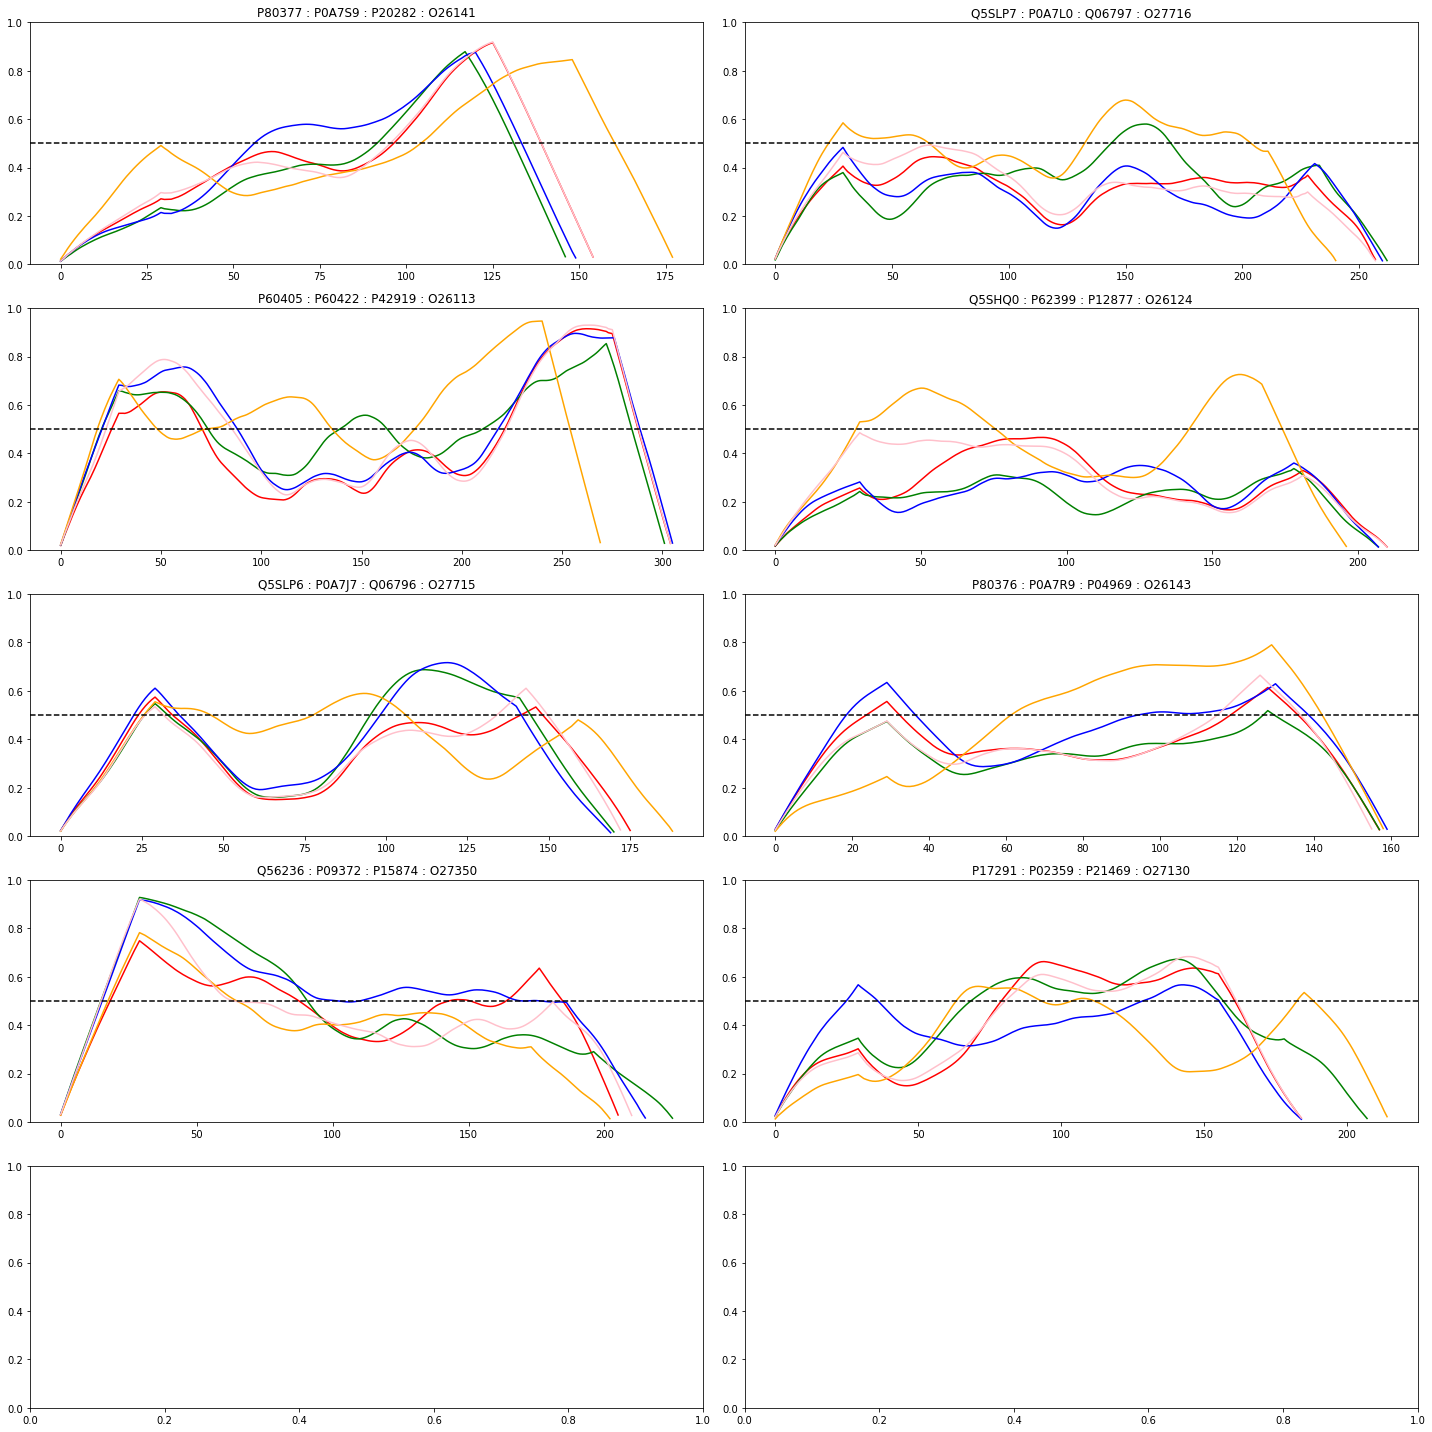

In [55]:
pairs_long = IDP_pairs.query("TT_disorder_binary_mean>=0.5 or EC_disorder_binary_mean>=0.5 or BS_disorder_binary_mean>=0.5 or MT_disorder_binary_mean>=0.5")

n_pairs = len(pairs_long)

conv = 30

fig, axs = plt.subplots(nrows=(n_pairs//2)+1, ncols=2, figsize=(20,20))
for i, ax in enumerate(fig.axes):
  if i < n_pairs:
    title = pairs_long.TT_ID.iloc[i] + ' : ' + pairs_long.EC_ID.iloc[i] + ' : '\
          + pairs_long.BS_ID.iloc[i] + ' : ' + pairs_long.MT_ID.iloc[i]
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(np.convolve(pairs_long.TT_disorder_combined.iloc[i], np.ones(conv)/conv), c='red')
    ax.plot(np.convolve(pairs_long.EC_disorder_combined.iloc[i], np.ones(conv)/conv), c='green')
    ax.plot(np.convolve(pairs_long.BS_disorder_combined.iloc[i], np.ones(conv)/conv), c='blue')
    ax.plot(np.convolve(pairs_long.MT_disorder_combined.iloc[i], np.ones(conv)/conv), c='orange')
    ax.plot(np.convolve(pairs_long.MH_disorder_combined.iloc[i], np.ones(conv)/conv), c='pink')
    ax.axhline(0.5, ls='--', c='black')

plt.tight_layout()

In [ ]:
query = "(TT_disorder_mean>=0.5 or MT_disorder_mean>=0.5) and (EC_disorder_mean<0.5 or BS_disorder_mean<0.5)"

IDP_pairs.query(query)[['TT_disorder_mean', 'EC_disorder_mean', 'BS_disorder_mean', 'MT_disorder_mean']]

,TT_disorder_mean,EC_disorder_mean,BS_disorder_mean,MT_disorder_mean
74,0.345668,0.376515,0.324419,0.512765
76,0.308121,0.252262,0.286088,0.508177
79,0.459937,0.412552,0.513128,0.557589
80,0.526830,0.486206,0.552310,0.542311
81,0.396367,0.375092,0.368935,0.520749
96,0.518155,0.402042,0.384804,0.385745


100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


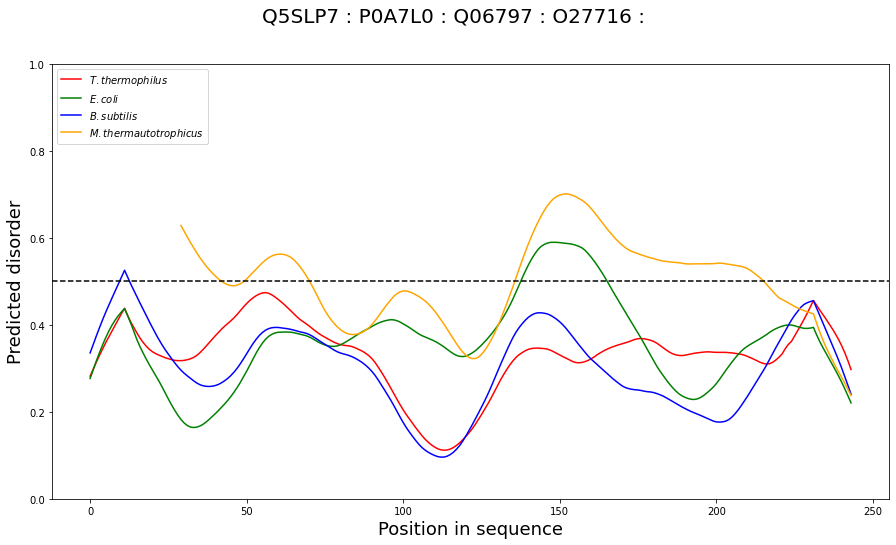

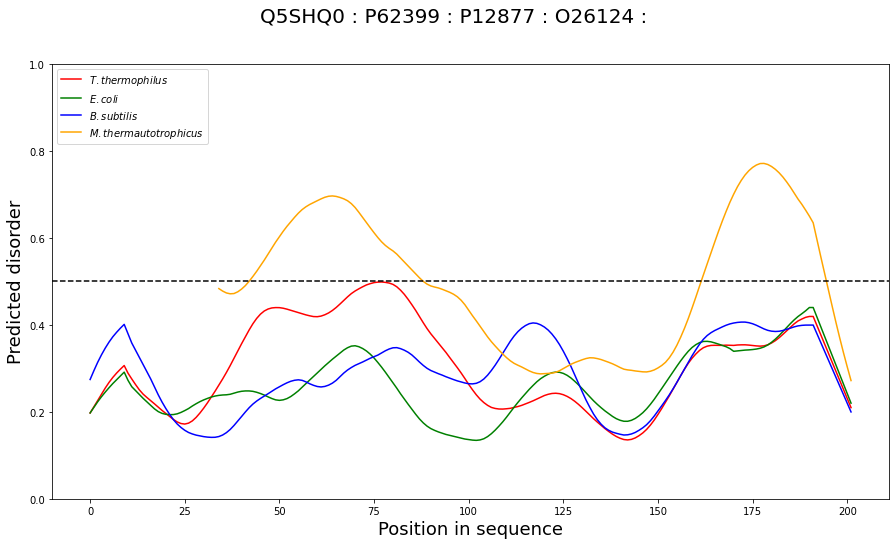

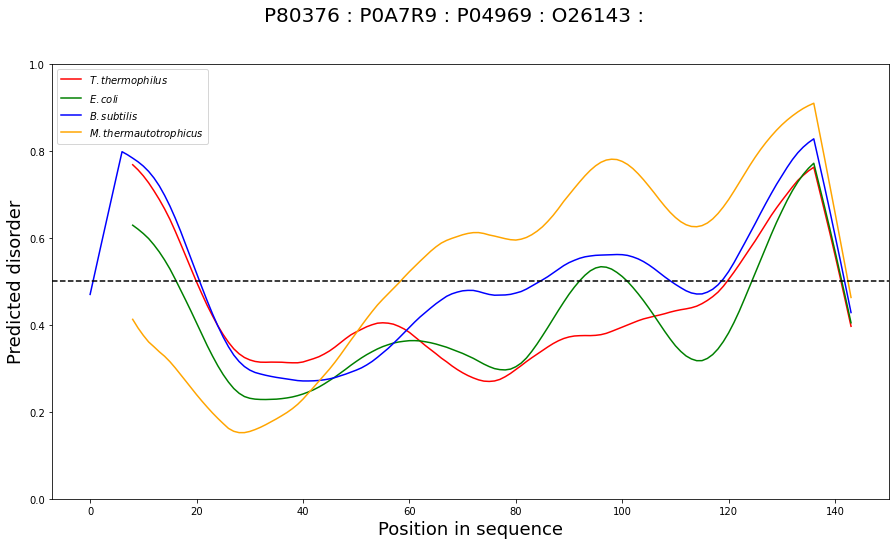

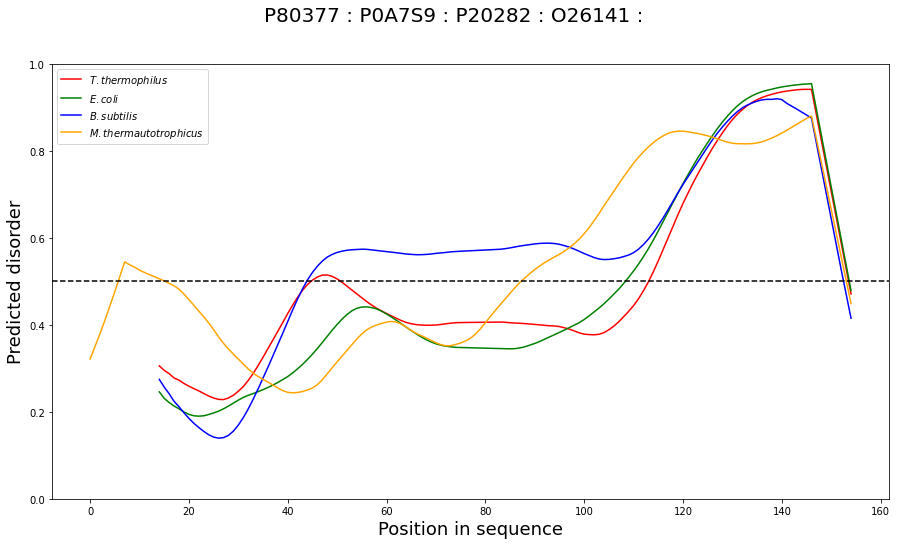

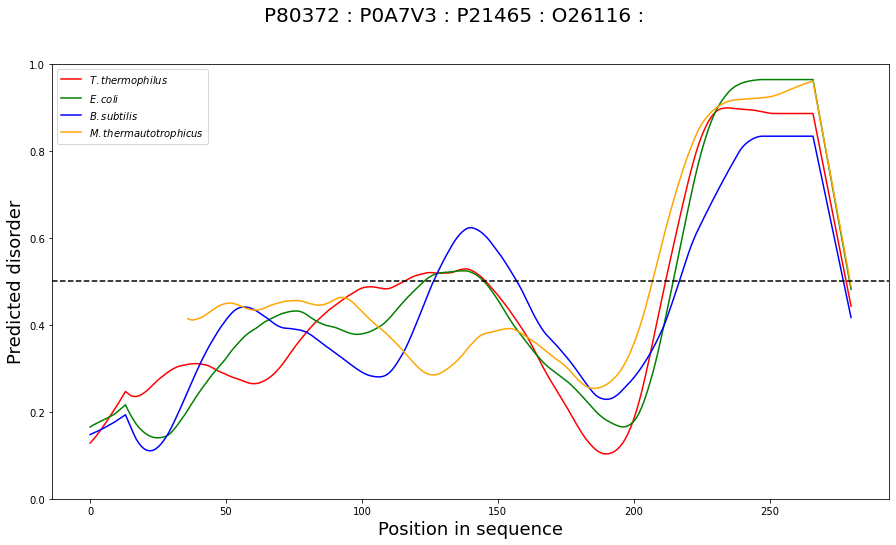

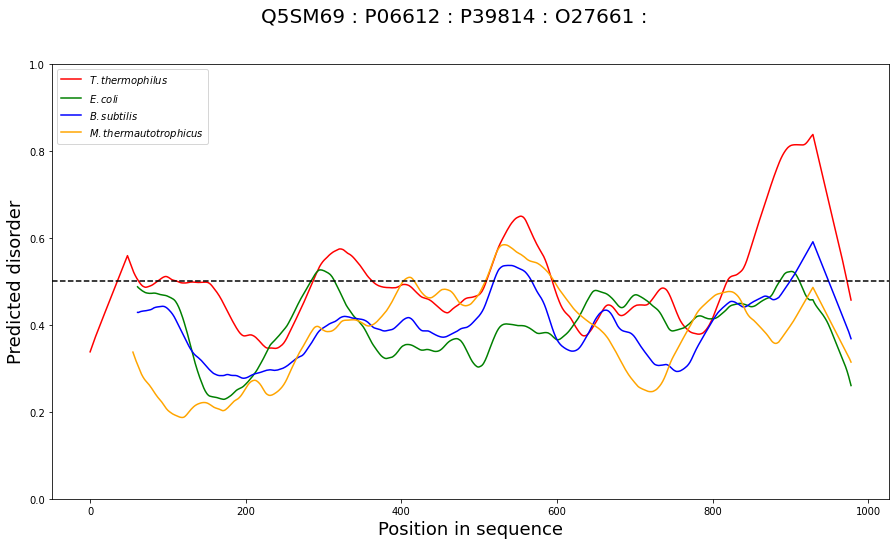

In [ ]:
for n in tqdm(IDP_pairs.query(query)[['TT_ID', 'EC_ID', 'BS_ID', 'MT_ID']].values):
  names = [*n]
  
  fig_name = ''.join([n + '-' for n in names])[:-1] + '.svg'

  labels = ['T. thermophilus', 'E. coli', 'B. subtilis', 'M. thermautotrophicus']

  disorder_values = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_disorder_combined.iloc[0],
                    IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_disorder_combined.iloc[0],
                    IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_disorder_combined.iloc[0],
                    IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_disorder_combined.iloc[0]]
  seqs = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_Sequence.iloc[0],
          IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_Sequence.iloc[0],
          IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_Sequence.iloc[0],
          IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_Sequence.iloc[0]]
  colors = ['red', 'green', 'blue', 'orange']

  plot_IDR_profile(disorder_values=disorder_values, seqs=seqs, labels=labels, colors=colors, names=names, mav=50, scale_mav=True,
                   gap_ins_pen=-5.0, gap_ext_pen=-0.5, savefig=True)

## Visualisation and statistical analysis



### Whole proteomes

MannwhitneyuResult(statistic=6702160.0, pvalue=1.7114621078226253e-138)
MannwhitneyuResult(statistic=6030197.0, pvalue=2.6955939395947783e-75)
MannwhitneyuResult(statistic=3836010.5, pvalue=2.6780356576906144e-34)
MannwhitneyuResult(statistic=8420357.0, pvalue=7.240380653788498e-15)
MannwhitneyuResult(statistic=5169481.0, pvalue=2.1140022604516405e-39)
MannwhitneyuResult(statistic=5616821.0, pvalue=2.7561883183637314e-09)


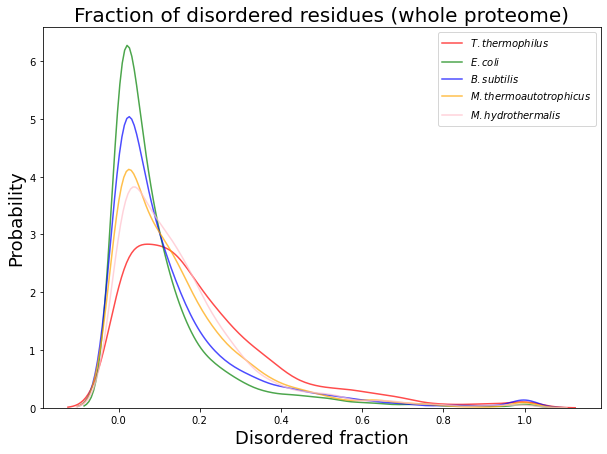

In [56]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_proteome.disorder_binary_mean,
                   'EC':EC_proteome.disorder_binary_mean,
                   'BS':BS_proteome.disorder_binary_mean,
                   'MT':MT_proteome.disorder_binary_mean,
                   'MH':MH_proteome.disorder_binary_mean})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
sns.kdeplot(df.MH, color='pink', alpha=0.7, label='$\\it{}$'.format('M. hydrothermalis'), ax=ax)
ax.set_title('Fraction of disordered residues (whole proteome)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.BS.dropna(), df.MT.dropna()))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (whole proteome).svg')

Ttest_indResult(statistic=22.664176266774415, pvalue=1.400841248830512e-109)
Ttest_indResult(statistic=15.621829585835187, pvalue=4.9716044140208e-54)
Ttest_indResult(statistic=9.77394096968593, pvalue=2.2870638085531894e-22)
Ttest_indResult(statistic=-7.038232254038612, pvalue=2.0956772244457214e-12)
Ttest_indResult(statistic=-13.396160311908238, pvalue=1.9178601797451406e-40)
Ttest_indResult(statistic=-6.288422675040285, pvalue=3.396428218378637e-10)


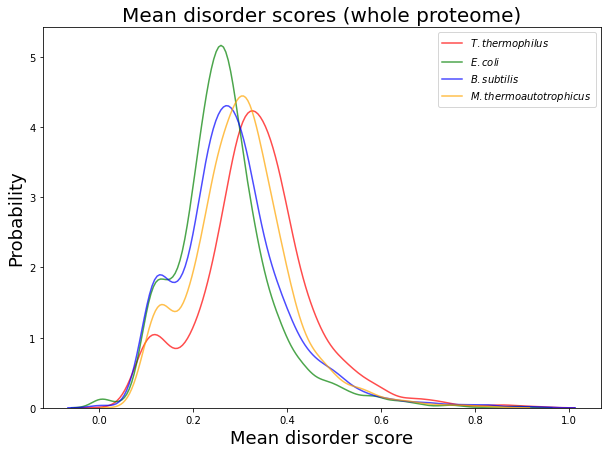

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_proteome.disorder_mean,
                   'EC':EC_proteome.disorder_mean,
                   'BS':BS_proteome.disorder_mean,
                   'MT':MT_proteome.disorder_mean})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
ax.set_title('Mean disorder scores (whole proteome)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_ind(df.TT, df.BS, nan_policy='omit'))
print(ttest_ind(df.TT, df.MT, nan_policy='omit'))
print(ttest_ind(df.EC, df.BS, nan_policy='omit'))
print(ttest_ind(df.EC, df.MT, nan_policy='omit'))
print(ttest_ind(df.BS, df.MT, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (whole proteome).svg')

WilcoxonResult(statistic=941.0, pvalue=1.4093630274708885e-09)
WilcoxonResult(statistic=1533.0, pvalue=2.5037245538701775e-05)
WilcoxonResult(statistic=2063.0, pvalue=0.006989898527122489)
WilcoxonResult(statistic=2291.0, pvalue=0.04566530819850966)
WilcoxonResult(statistic=1633.0, pvalue=0.00015055658060252535)
WilcoxonResult(statistic=2396.0, pvalue=0.0936143120943661)


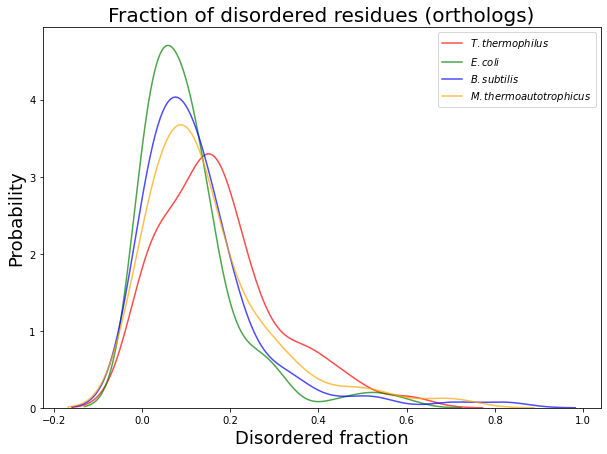

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'BS':IDP_pairs.BS_disorder_binary_mean,
                   'MT':IDP_pairs.MT_disorder_binary_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR +\
                              IDP_pairs.BS_longest_IDR + IDP_pairs.MT_longest_IDR) / 4})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
ax.set_title('Fraction of disordered residues (orthologs)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(wilcoxon(df.TT.dropna(), df.EC.dropna()))
print(wilcoxon(df.TT.dropna(), df.BS.dropna()))
print(wilcoxon(df.TT.dropna(), df.MT.dropna()))
print(wilcoxon(df.EC.dropna(), df.BS.dropna()))
print(wilcoxon(df.EC.dropna(), df.MT.dropna()))
print(wilcoxon(df.BS.dropna(), df.MT.dropna()))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (orthologs).svg')

Ttest_relResult(statistic=8.419110311827426, pvalue=1.6658017223747937e-13)
Ttest_relResult(statistic=4.3468295166541955, pvalue=3.115230694089152e-05)
Ttest_relResult(statistic=0.8499142802358388, pvalue=0.3972357339052468)
Ttest_relResult(statistic=-3.737470145183143, pvalue=0.00029784892507082856)
Ttest_relResult(statistic=-7.004499840310849, pvalue=2.14516575661678e-10)
Ttest_relResult(statistic=-3.39423199337307, pvalue=0.0009605913677187775)


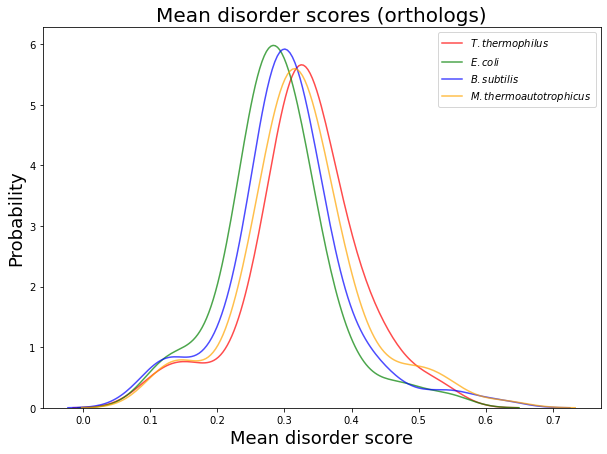

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
ax.set_title('Mean disorder scores (orthologs)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.BS, nan_policy='omit'))
print(ttest_rel(df.TT, df.MT, nan_policy='omit'))
print(ttest_rel(df.EC, df.BS, nan_policy='omit'))
print(ttest_rel(df.EC, df.MT, nan_policy='omit'))
print(ttest_rel(df.BS, df.MT, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (orthologs).svg')

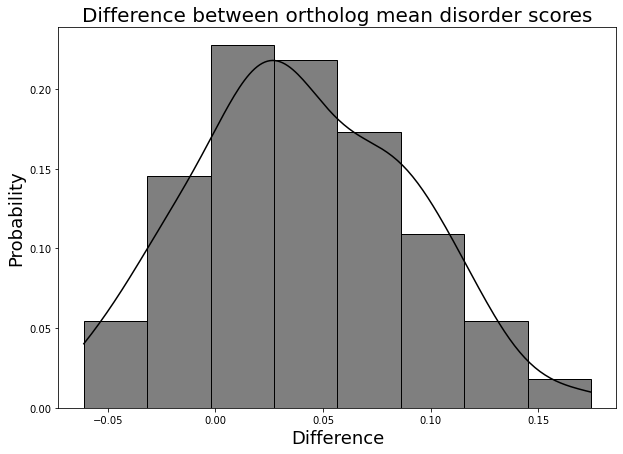

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean})

df['diff'] = df.TT - df.EC

sns.histplot(df['diff'], color='black', kde=True, alpha=0.5, stat='probability', ax=ax)
ax.set_title('Difference between ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Difference', fontsize=18)

fig.show()
fig.savefig('Difference between ortholog mean disorder scores.png')

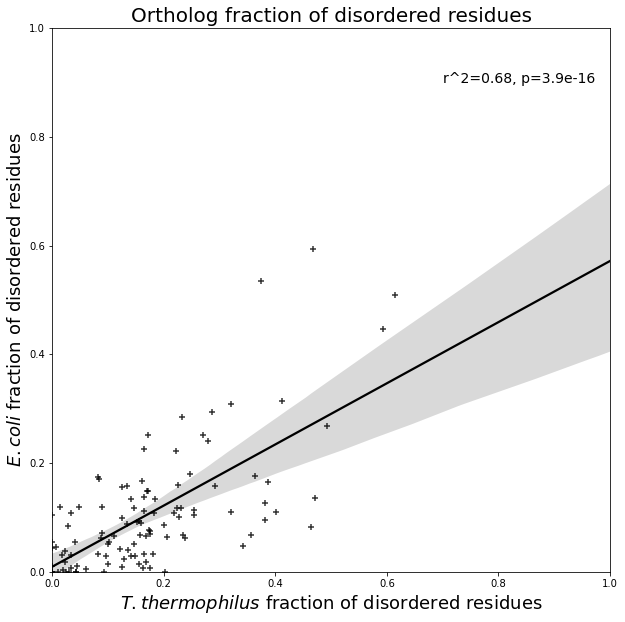

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog fraction of disordered residues', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' fraction of disordered residues', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' fraction of disordered residues', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog fraction of disordered residues.svg')

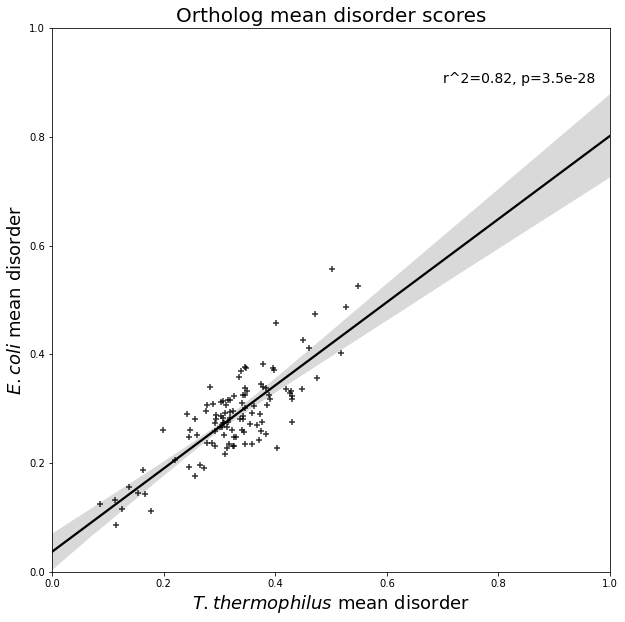

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores.png')

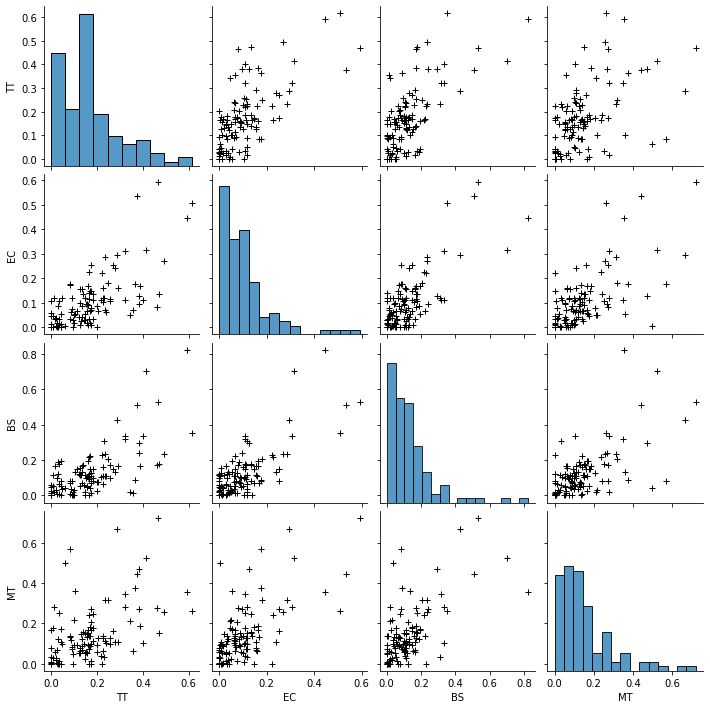

In [ ]:
df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'BS':IDP_pairs.BS_disorder_binary_mean,
                   'MT':IDP_pairs.MT_disorder_binary_mean})

sns.pairplot(df, plot_kws=dict(marker="+", linewidth=1, color='black'))

In [ ]:
for i in ['TT', 'EC', 'BS']:
  for j in ['EC', 'BS', 'MT']:
    if i != j:
      rsq = pearsonr(df[i], df[j])
      print(i, j, round(rsq[0], 3), round(rsq[1], 10), sep=' - ')

TT - EC - 0.678 - 0.0
TT - BS - 0.67 - 0.0
TT - MT - 0.493 - 4.49e-08
EC - BS - 0.744 - 0.0
EC - MT - 0.636 - 0.0
BS - EC - 0.744 - 0.0
BS - MT - 0.614 - 0.0


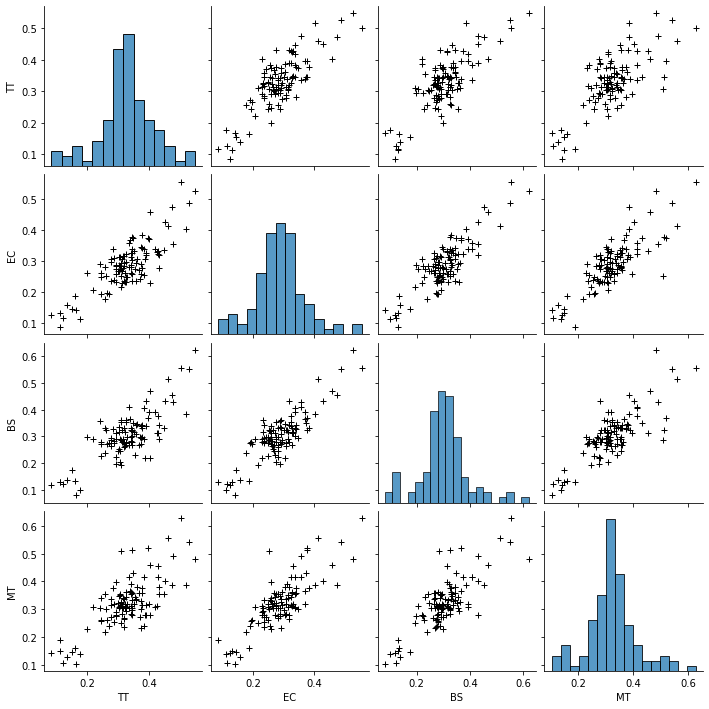

In [ ]:
df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean})

sns.pairplot(df, plot_kws=dict(marker="+", linewidth=1, color='black'))

In [ ]:
for i in ['TT', 'EC', 'BS']:
  for j in ['EC', 'BS', 'MT']:
    if i != j:
      rsq = pearsonr(df[i], df[j])
      print(i, j, round(rsq[0], 3), round(rsq[1], 10), sep=' - ')

TT - EC - 0.822 - 0.0
TT - BS - 0.788 - 0.0
TT - MT - 0.742 - 0.0
EC - BS - 0.856 - 0.0
EC - MT - 0.822 - 0.0
BS - EC - 0.856 - 0.0
BS - MT - 0.8 - 0.0


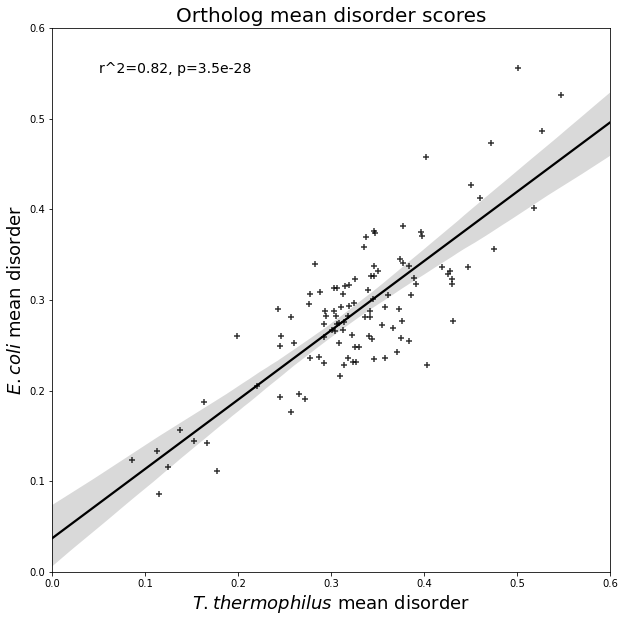

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - EC.svg')

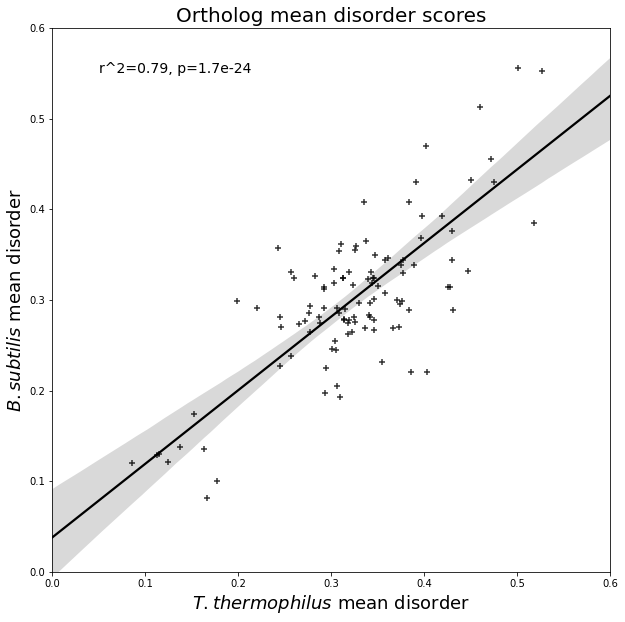

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.BS_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.BS, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.BS)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - BS.svg')

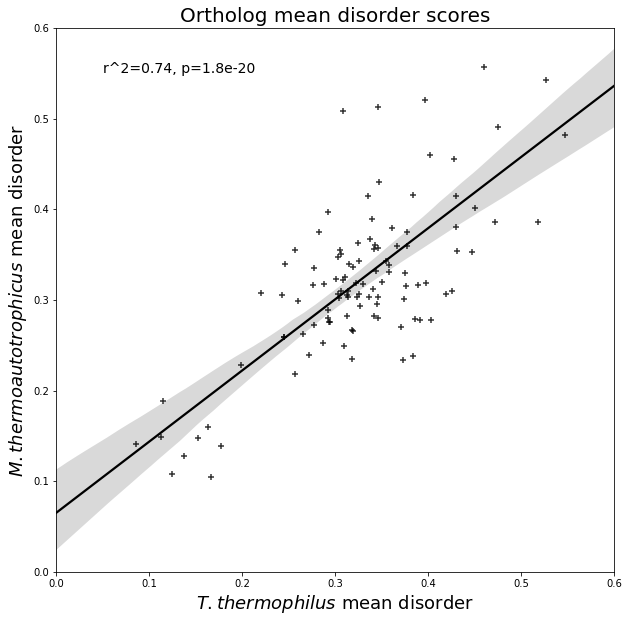

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - MT.svg')

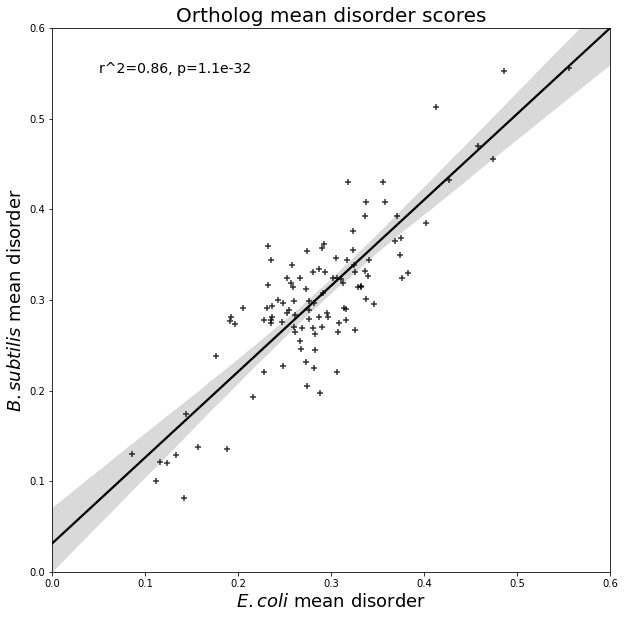

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'EC':IDP_pairs.EC_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'dis_len':(IDP_pairs.EC_longest_IDR + IDP_pairs.BS_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.EC, y=df.BS, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.EC, df.BS)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: EC - BS.svg')

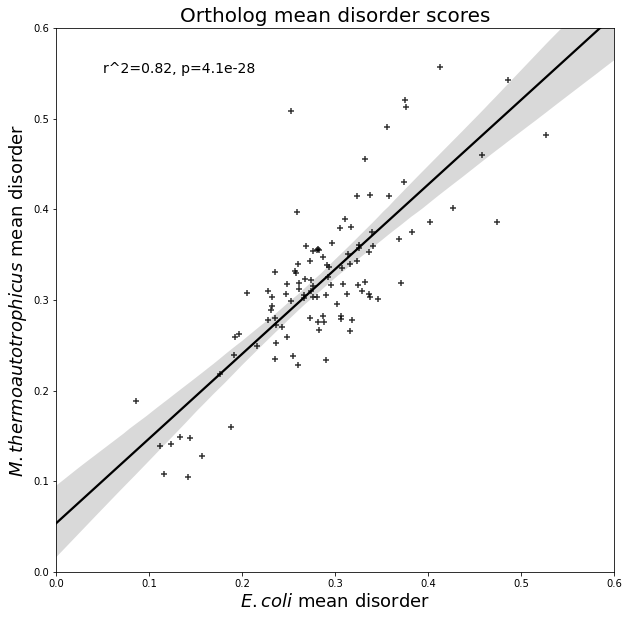

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'EC':IDP_pairs.EC_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.EC_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.EC, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.EC, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: EC - MT.svg')

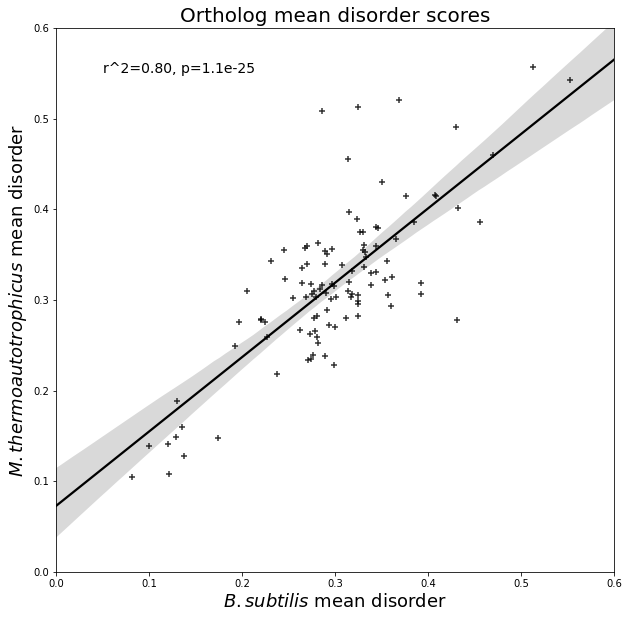

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.BS_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.BS, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.BS, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: BS - MT.svg')

### Exclusive to each proteome

In [ ]:
TT_only = TT_proteome[~TT_proteome.ID.isin(IDP_pairs.TT_ID)]
EC_only = EC_proteome[~EC_proteome.ID.isin(IDP_pairs.EC_ID)]
BS_only = BS_proteome[~BS_proteome.ID.isin(IDP_pairs.BS_ID)]
MT_only = MT_proteome[~MT_proteome.ID.isin(IDP_pairs.MT_ID)]

MannwhitneyuResult(statistic=6214936.0, pvalue=1.5287547974355741e-133)
MannwhitneyuResult(statistic=5587963.0, pvalue=8.445133550469594e-73)
MannwhitneyuResult(statistic=3513019.5, pvalue=1.635925797057995e-33)
MannwhitneyuResult(statistic=7999689.0, pvalue=1.948989172913131e-14)
MannwhitneyuResult(statistic=4855540.0, pvalue=1.3096085084022392e-37)
MannwhitneyuResult(statistic=5268801.0, pvalue=7.959207938318969e-09)


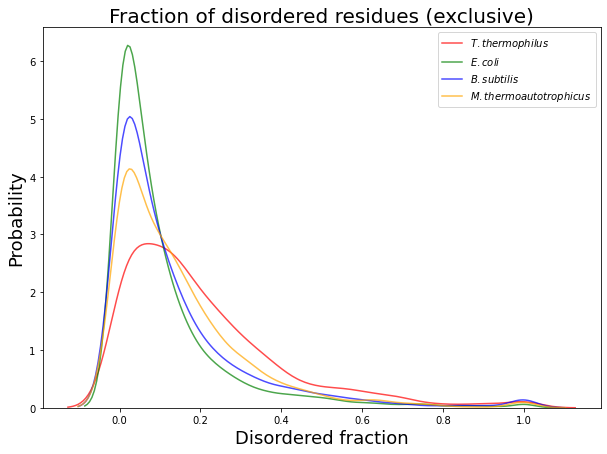

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_only.disorder_binary_mean,
                   'EC':EC_only.disorder_binary_mean,
                   'BS':BS_only.disorder_binary_mean,
                   'MT':MT_only.disorder_binary_mean})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
ax.set_title('Fraction of disordered residues (exclusive)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.BS.dropna(), df.MT.dropna()))

fig.show()
fig.savefig('Fraction of disordered residues (exclusive).svg')

Ttest_indResult(statistic=22.300648554560937, pvalue=3.7798189047354386e-106)
Ttest_indResult(statistic=15.42800420487038, pvalue=9.85649557053781e-53)
Ttest_indResult(statistic=9.806488065938215, pvalue=1.7017290650383688e-22)
Ttest_indResult(statistic=-6.911516194976252, pvalue=5.144484600237685e-12)
Ttest_indResult(statistic=-12.99379020369, pvalue=3.6345940402526326e-38)
Ttest_indResult(statistic=-6.043600593981479, pvalue=1.585509937854326e-09)


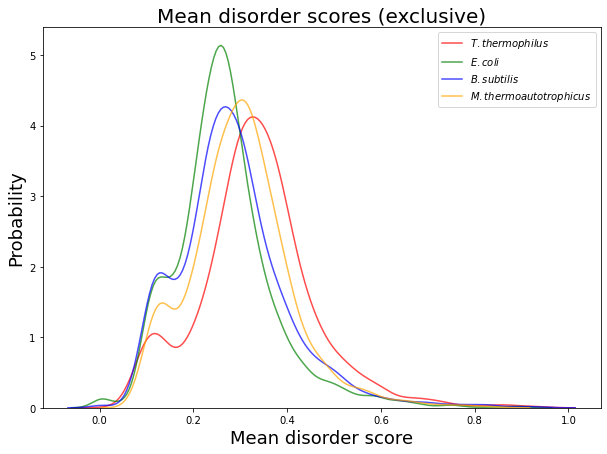

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_only.disorder_mean,
                   'EC':EC_only.disorder_mean,
                   'BS':BS_only.disorder_mean,
                   'MT':MT_only.disorder_mean})

sns.kdeplot(df.TT, color='red', alpha=0.7, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.7, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.7, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.MT, color='orange', alpha=0.7, label='$\\it{}$'.format('M. thermoautotrophicus'), ax=ax)
ax.set_title('Mean disorder scores (exclusive)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_ind(df.TT, df.BS, nan_policy='omit'))
print(ttest_ind(df.TT, df.MT, nan_policy='omit'))
print(ttest_ind(df.EC, df.BS, nan_policy='omit'))
print(ttest_ind(df.EC, df.MT, nan_policy='omit'))
print(ttest_ind(df.BS, df.MT, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (exclusive).png')

### Exclusive to each proteome - most disordered

In [ ]:
n_top = 10

TT_only_top = TT_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]
EC_only_top = EC_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]

In [ ]:
TT_only_top

,ID,Sequence,Length,disorder,disorder_combined,disorder_binary,disorder_mean,disorder_binary_mean,longest_IDR
1723,Q5SKG1,MVRYEPALPLPSYTVRLAPVPVEAVREEAKPQAPIPEARPAEASRP...,383,VLXT VL3 VSL2 iupred3 0 ...,0 0.731157 1 0.704974 2 0.64389...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.728770,0.751958,263
187,Q5SKU1,MPKMKTHKGAKKRVKITASGKVVAMKTGKRHLNWQKSGKEIRQKGR...,65,VLXT VL3 VSL2 iupred3 0 0...,0 0.946002 1 0.943044 2 0.933056 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.720541,0.923077,59
1091,Q5SII7,MKNAWQRLKEAWANLPRSTKLLLAALLLVGNVALWYVGLYLPAQVA...,292,VLXT VL3 VSL2 iupred3 0 ...,0 0.513942 1 0.497946 2 0.43485...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.715382,0.787671,185
505,Q5SJ63,MGAVAMTSCPFSRLSPTRMASSASFSRLRLKASTPQVFARKGLPSR...,159,VLXT VL3 VSL2 iupred3 0 ...,0 0.774529 1 0.751124 2 0.75150...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.711813,0.880503,95
1665,Q53WE8,MRKKRKVQSLEEIPKFRSEEEEARFWAEHELDEPLLEAMAPPPEGL...,102,VLXT VL3 VSL2 iupred3 0 ...,0 0.801418 1 0.788319 2 0.78029...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.697207,0.901961,81
1110,Q5SH39,MEEPKITPLARRLAEENGIDWRKLQGTGPDGLIVERDILAYLAKVM...,340,VLXT VL3 VSL2 iupred3 0 ...,0 0.736265 1 0.701624 2 0.70264...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0.692195,0.694118,163
273,Q5SHQ7,MKLSDLRPNPGANKRRKRVGRGPGSGHGKTATRGHKGQKSRSGGLK...,150,VLXT VL3 VSL2 iupred3 0 ...,0 0.896175 1 0.888506 2 0.90812...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.690112,0.706667,92
1447,Q53W16,MKRKSAYSPSAREKLAFKIPVRRSGQRHYSTSLKRCTPSKCASKRT...,152,VLXT VL3 VSL2 iupred3 0 ...,0 0.875352 1 0.842376 2 0.85797...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.681028,0.782895,69
196,Q7X5K6,MDEKDVATQPQETGQNPRLSGQDEDPGRPEGAEAPPSEGALAPHAR...,163,VLXT VL3 VSL2 iupred3 0 ...,0 0.959345 1 0.952084 2 0.94096...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.665711,0.674847,86
1315,Q5SJG1,MSLDDLLGLLFVLFFIVLPALQGLFRRNPPPDLPFPVEGELEAPPP...,117,VLXT VL3 VSL2 iupred3 0 ...,0 0.535613 1 0.494300 2 0.46535...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.655895,0.641026,73


In [ ]:
EC_only_top

,ID,Sequence,Length,disorder,disorder_combined,disorder_binary,disorder_mean,disorder_binary_mean,longest_IDR
4004,P11557,MDEFKPEDELKPDPSDRRTGRSRQSSERSERTERGEPQINFDDIEL...,428,VLXT VL3 VSL2 iupred3 0 ...,0 0.933892 1 0.946573 2 0.95472...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.752406,0.829439,231
512,P0AEM4,MSIDRTSPLKPVSTVQPRETTDAPVTNSRAAKTTASTSTSVTLSDA...,97,VLXT VL3 VSL2 iupred3 0 0...,0 0.839892 1 0.828722 2 0.845185 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.689316,0.865979,71
3779,P29131,MAQRDYVRRSQPAPSRRKKSTSRKKQRNLPAVSPAMVAIAAAVLVT...,319,VLXT VL3 VSL2 iupred3 0 ...,0 0.822267 1 0.803603 2 0.80040...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.682647,0.708464,190
1379,P0A7Q1,MPKIKTVRGAAKRFKKTGKGGFKHKHANLRHILTKKATKRKRHLRP...,65,VLXT VL3 VSL2 iupred3 0 0...,0 0.843519 1 0.824686 2 0.812125 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.657112,0.769231,50
4235,P77609,MSVTIQGNTSTVISNNSAPEGTSEIAKITRQIQVLTEKLGKISSEE...,110,VLXT VL3 VSL2 iupred3 0 ...,0 0.663870 1 0.634168 2 0.57032...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.643181,0.918182,59
1260,P52614,MIRLAPLITADVDTTTLPGGKASDAAQDFLALLSEALAGETTTDKA...,375,VLXT VL3 VSL2 iupred3 0 ...,0 0.372377 1 0.340269 2 0.29045...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.639974,0.752000,101
2287,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,VLXT VL3 VSL2 iupred3 0 ...,0 0.561418 1 0.559397 2 0.54873...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.633345,0.631799,133
190,P0ACG1,MSVMLQSLNNIRTLRAMAREFSIDVLEEMLEKFRVVTKERREEEEQ...,134,VLXT VL3 VSL2 iupred3 0 ...,0 0.580502 1 0.567176 2 0.52215...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.609643,0.723881,79
1562,P77754,MRKLTALFVASTLALGAANLAHAADTTTAAPADAKPMMHHKGKFGP...,161,VLXT VL3 VSL2 iupred3 0 ...,0 0.434791 1 0.391242 2 0.32782...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.608473,0.788820,99
145,P19934,MSKATEQNDKLKRAIIISAVLHVILFAALIWSSFDENIEASAGGGG...,421,VLXT VL3 VSL2 iupred3 0 ...,0 0.729605 1 0.731195 2 0.71318...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.605853,0.755344,298


### Separate models

In [ ]:
species = ['T. thermophilus', 'E. coli', 'B. subtilis', 'M. thermoautotrophicus']

In [ ]:
TT_separate_models_means = {}
for m in models:
  TT_separate_models_means[m] = [np.mean(TT_proteome.disorder.iloc[n][m]) for n in range(len(TT_proteome))]
TT_separate_models_means = pd.DataFrame(TT_separate_models_means).melt(var_name='model', value_name='mean_disorder')

EC_separate_models_means = {}
for m in models:
  EC_separate_models_means[m] = [np.mean(EC_proteome.disorder.iloc[n][m]) for n in range(len(EC_proteome))]
EC_separate_models_means = pd.DataFrame(EC_separate_models_means).melt(var_name='model', value_name='mean_disorder')

BS_separate_models_means = {}
for m in models:
  BS_separate_models_means[m] = [np.mean(BS_proteome.disorder.iloc[n][m]) for n in range(len(BS_proteome))]
BS_separate_models_means = pd.DataFrame(BS_separate_models_means).melt(var_name='model', value_name='mean_disorder')

MT_separate_models_means = {}
for m in models:
  MT_separate_models_means[m] = [np.mean(MT_proteome.disorder.iloc[n][m]) for n in range(len(MT_proteome))]
MT_separate_models_means = pd.DataFrame(MT_separate_models_means).melt(var_name='model', value_name='mean_disorder')

In [ ]:
TT_separate_models_means['species'] = species[0]
EC_separate_models_means['species'] = species[1]
BS_separate_models_means['species'] = species[2]
MT_separate_models_means['species'] = species[3]

In [ ]:
model_means = pd.concat([TT_separate_models_means, EC_separate_models_means,
                         BS_separate_models_means, MT_separate_models_means])

Ttest_indResult(statistic=32.36675552949413, pvalue=2.5899389908421e-213)
Ttest_indResult(statistic=34.0005741610309, pvalue=3.020178072615297e-233)
Ttest_indResult(statistic=11.8296459975615, pvalue=7.138280881240204e-32)
Ttest_indResult(statistic=3.537646934609012, pvalue=0.0004058473814389647)
Ttest_indResult(statistic=-20.13662489361505, pvalue=8.868632269217783e-88)
Ttest_indResult(statistic=-22.484013617712083, pvalue=3.2536789156884653e-108)


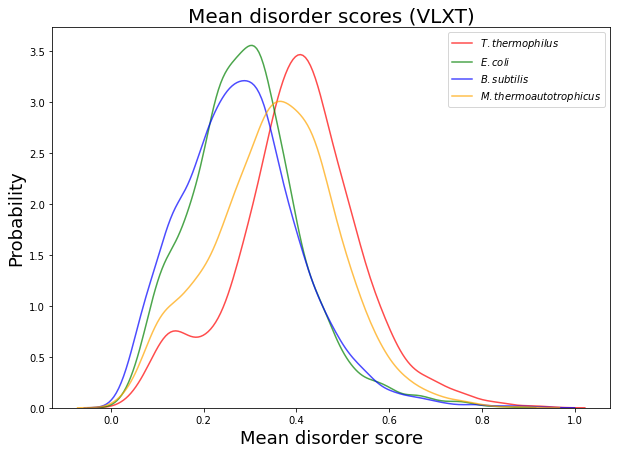

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[0]

title = 'Mean disorder scores (' + m + ')'

df = model_means[model_means.model==m]

sns.kdeplot(df[df.species==species[0]].mean_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].mean_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].mean_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].mean_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[1]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=30.905665658660737, pvalue=6.963108663768466e-196)
Ttest_indResult(statistic=16.774659810011322, pvalue=7.523932412922045e-62)
Ttest_indResult(statistic=12.54565470118234, pvalue=1.401962483784524e-35)
Ttest_indResult(statistic=-15.41217239624407, pvalue=6.929840298750348e-53)
Ttest_indResult(statistic=-18.911887777841834, pvalue=6.856970921345408e-78)
Ttest_indResult(statistic=-4.023245875577868, pvalue=5.7995930051131896e-05)


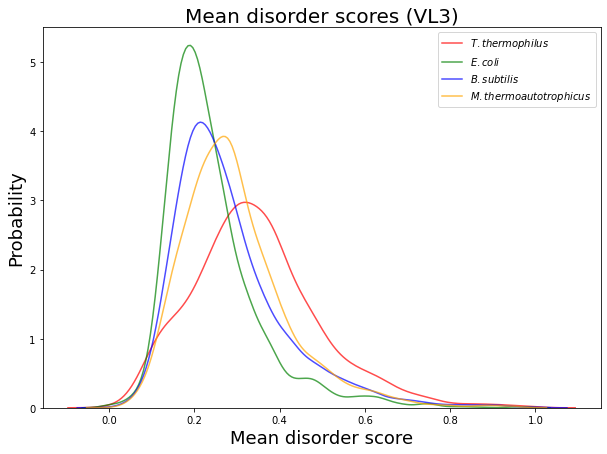

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[1]

title = 'Mean disorder scores (' + m + ')'

df = model_means[model_means.model==m]

sns.kdeplot(df[df.species==species[0]].mean_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].mean_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].mean_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].mean_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[1]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=16.94246474069484, pvalue=4.762479734274423e-63)
Ttest_indResult(statistic=6.4318958854527555, pvalue=1.3504510694011418e-10)
Ttest_indResult(statistic=7.976254143205175, pvalue=1.84786011146979e-15)
Ttest_indResult(statistic=-11.484708257055825, pvalue=2.623569368335068e-30)
Ttest_indResult(statistic=-9.22076450221905, pvalue=3.80573473054341e-20)
Ttest_indResult(statistic=1.7514549222231797, pvalue=0.07991065221898806)


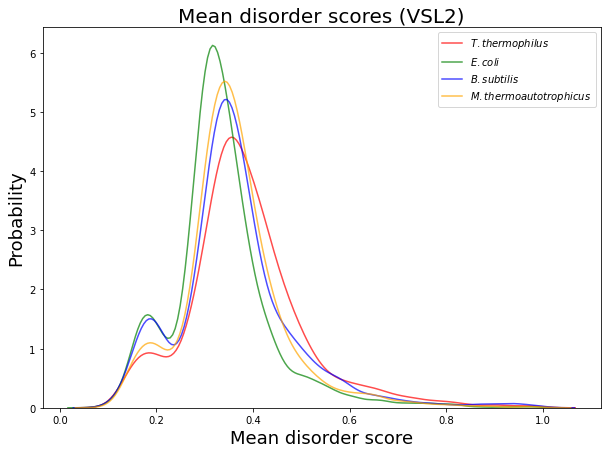

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[2]

title = 'Mean disorder scores (' + m + ')'

df = model_means[model_means.model==m]

sns.kdeplot(df[df.species==species[0]].mean_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].mean_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].mean_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].mean_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[1]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=0.12179913111493847, pvalue=0.9030618079060828)
Ttest_indResult(statistic=-1.226636648096353, pvalue=0.22000383190250916)
Ttest_indResult(statistic=2.223911290147546, pvalue=0.026198050468194935)
Ttest_indResult(statistic=-1.6362545137042919, pvalue=0.10182278362482396)
Ttest_indResult(statistic=2.4080185315700384, pvalue=0.01606413061299942)
Ttest_indResult(statistic=3.6866828293759153, pvalue=0.0002288841039104369)


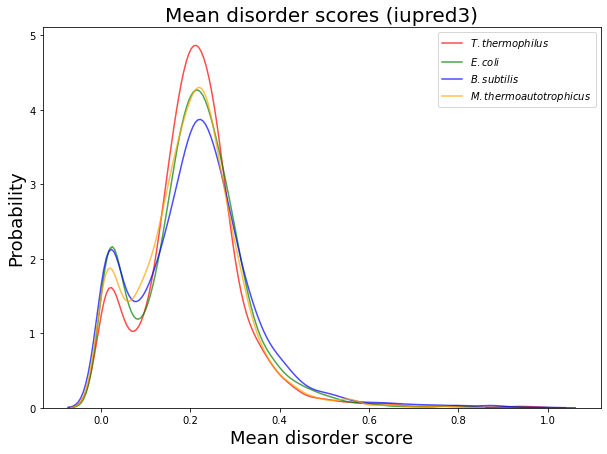

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[3]

title = 'Mean disorder scores (' + m + ')'

df = model_means[model_means.model==m]

sns.kdeplot(df[df.species==species[0]].mean_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].mean_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].mean_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].mean_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[1]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[2]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].mean_disorder, df[df.species==species[3]].mean_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

In [ ]:
TT_separate_models_binary = {}
for m in models:
  TT_separate_models_binary[m] = [np.mean(binary_disorder(TT_proteome.disorder.iloc[n][m])) for n in range(len(TT_proteome))]
TT_separate_models_binary = pd.DataFrame(TT_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

EC_separate_models_binary = {}
for m in models:
  EC_separate_models_binary[m] = [np.mean(binary_disorder(EC_proteome.disorder.iloc[n][m])) for n in range(len(EC_proteome))]
EC_separate_models_binary = pd.DataFrame(EC_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

BS_separate_models_binary = {}
for m in models:
  BS_separate_models_binary[m] = [np.mean(binary_disorder(BS_proteome.disorder.iloc[n][m])) for n in range(len(BS_proteome))]
BS_separate_models_binary = pd.DataFrame(BS_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

MT_separate_models_binary = {}
for m in models:
  MT_separate_models_binary[m] = [np.mean(binary_disorder(MT_proteome.disorder.iloc[n][m])) for n in range(len(MT_proteome))]
MT_separate_models_binary = pd.DataFrame(MT_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

In [ ]:
TT_separate_models_binary['species'] = species[0]
EC_separate_models_binary['species'] = species[1]
BS_separate_models_binary['species'] = species[2]
MT_separate_models_binary['species'] = species[3]

In [ ]:
model_binary = pd.concat([TT_separate_models_binary, EC_separate_models_binary,
                          BS_separate_models_binary, MT_separate_models_binary])

Ttest_indResult(statistic=33.495909161377014, pvalue=2.4636657367991177e-227)
Ttest_indResult(statistic=32.56560168103686, pvalue=1.4743282497726023e-215)
Ttest_indResult(statistic=11.423285459043232, pvalue=7.360905744616408e-30)
Ttest_indResult(statistic=0.17819548268290514, pvalue=0.8585736378509388)
Ttest_indResult(statistic=-21.717070558810494, pvalue=2.2486661676475908e-101)
Ttest_indResult(statistic=-21.20161230991723, pvalue=8.545740011645105e-97)


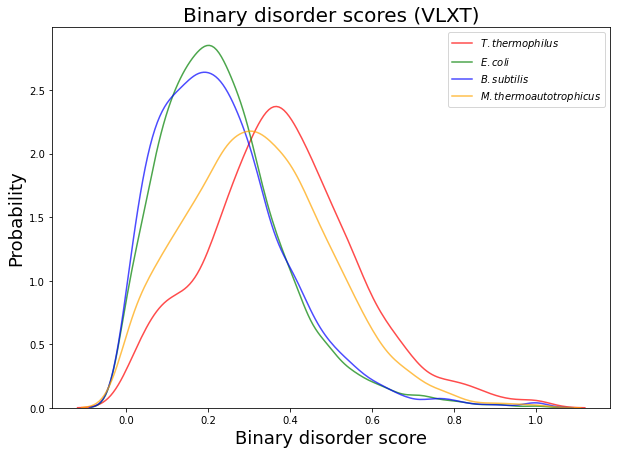

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[0]

title = 'Binary disorder scores (' + m + ')'

df = model_binary[model_binary.model==m]

sns.kdeplot(df[df.species==species[0]].binary_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].binary_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].binary_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].binary_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Binary disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[1]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=30.517537478887917, pvalue=1.814062592251612e-191)
Ttest_indResult(statistic=17.72197391096687, pvalue=1.1663629096320152e-68)
Ttest_indResult(statistic=15.599691316979571, pvalue=1.2482290131618697e-53)
Ttest_indResult(statistic=-12.900169683451667, pvalue=1.0007478103557923e-37)
Ttest_indResult(statistic=-13.59241772971144, pvalue=1.4278607034747903e-41)
Ttest_indResult(statistic=-1.2840551498966304, pvalue=0.19916438232715528)


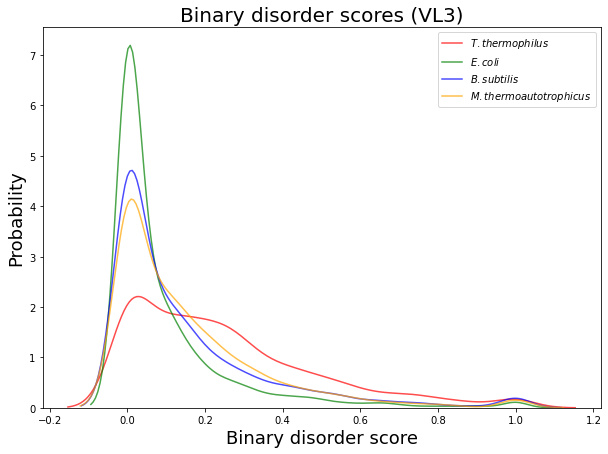

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[1]

title = 'Binary disorder scores (' + m + ')'

df = model_binary[model_binary.model==m]

sns.kdeplot(df[df.species==species[0]].binary_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].binary_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].binary_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].binary_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Binary disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[1]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=16.93078579894365, pvalue=5.603169986301344e-63)
Ttest_indResult(statistic=4.317714112904537, pvalue=1.6000651901328857e-05)
Ttest_indResult(statistic=7.333737890725937, pvalue=2.590074886400628e-13)
Ttest_indResult(statistic=-14.589482326897953, pvalue=1.2057538419720753e-47)
Ttest_indResult(statistic=-9.839394092044259, pvalue=1.055594207868887e-22)
Ttest_indResult(statistic=3.673325103206876, pvalue=0.00024116858904323798)


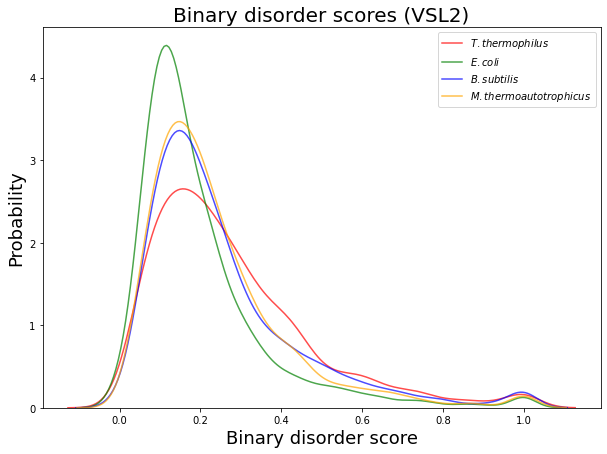

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[2]

title = 'Binary disorder scores (' + m + ')'

df = model_binary[model_binary.model==m]

sns.kdeplot(df[df.species==species[0]].binary_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].binary_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].binary_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].binary_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Binary disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[1]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

Ttest_indResult(statistic=-0.2884639542505812, pvalue=0.7730006718239288)
Ttest_indResult(statistic=-2.919984531958392, pvalue=0.0035125712813826593)
Ttest_indResult(statistic=2.3601440579353543, pvalue=0.01830528577005972)
Ttest_indResult(statistic=-3.3605777353919226, pvalue=0.0007811691328778462)
Ttest_indResult(statistic=3.057164209124373, pvalue=0.0022425414605645845)
Ttest_indResult(statistic=5.633470482169449, pvalue=1.8334989685983855e-08)


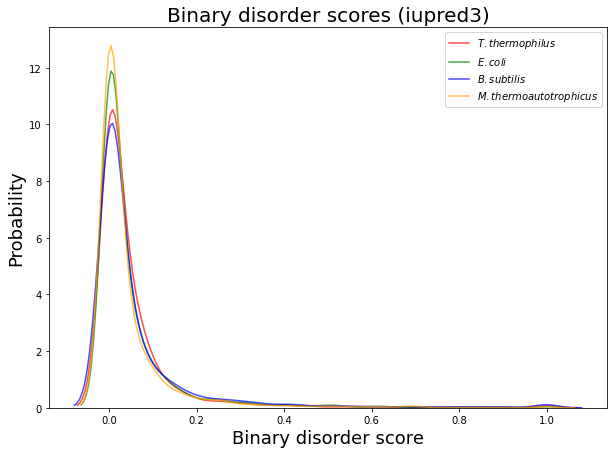

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

m = models[3]

title = 'Binary disorder scores (' + m + ')'

df = model_binary[model_binary.model==m]

sns.kdeplot(df[df.species==species[0]].binary_disorder,
            color='red', alpha=0.7, label='$\\it{}$'.format(species[0]), ax=ax)
sns.kdeplot(df[df.species==species[1]].binary_disorder,
            color='green', alpha=0.7, label='$\\it{}$'.format(species[1]), ax=ax)
sns.kdeplot(df[df.species==species[2]].binary_disorder,
            color='blue', alpha=0.7, label='$\\it{}$'.format(species[2]), ax=ax)
sns.kdeplot(df[df.species==species[3]].binary_disorder,
            color='orange', alpha=0.7, label='$\\it{}$'.format(species[3]), ax=ax)
ax.set_title(title, fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Binary disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[1]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[0]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[2]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[1]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
print(ttest_ind(df[df.species==species[2]].binary_disorder, df[df.species==species[3]].binary_disorder, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig(title + '.svg')

## Charge / hydrophobicity

We use a custom function to calculate mean net charge and mean hydrophobicity for the amino acid sequences. The calcuations are based on [Uversky et.al. 2000 paper](https://doi.org/10.1002/1097-0134(20001115)41:3%3C415::AID-PROT130%3E3.0.CO;2-7)

In [ ]:
for df in [TT_proteome, EC_proteome, BS_proteome, MT_proteome]:
  df['charge_hydrophobicity'] = df.Sequence.apply(get_charge_hydrophobicity)
  df[['mean_net_charge', 'mean_hydrophobicity']] = pd.DataFrame(df['charge_hydrophobicity'].tolist(), index=df.index)
  df['Fraction of disorder'] = df.disorder_binary_mean * 100

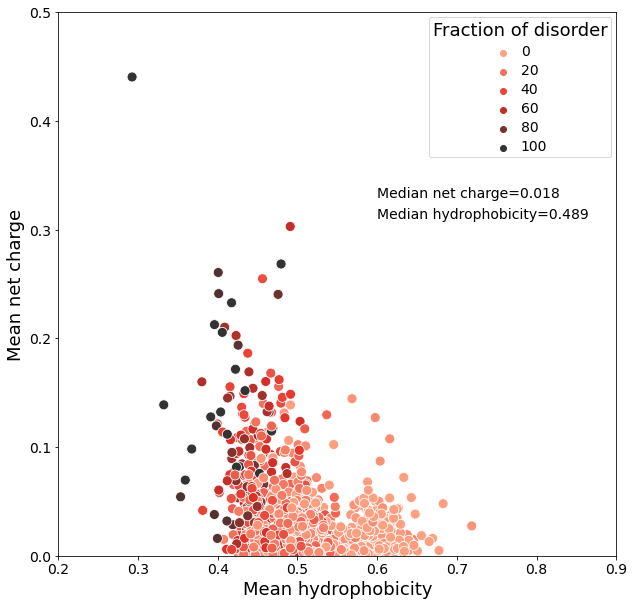

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=TT_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Reds_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = TT_proteome.mean_net_charge.median()
median_hydro = TT_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('TT_proteome_chplot.svg')

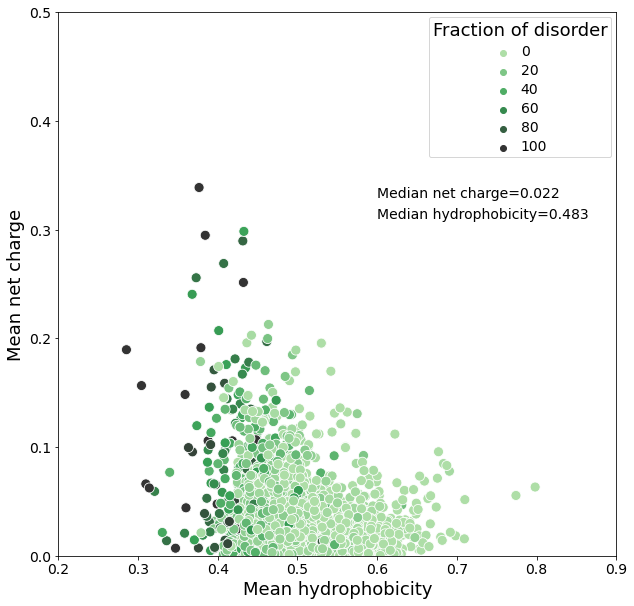

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=EC_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Greens_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = EC_proteome.mean_net_charge.median()
median_hydro = EC_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('EC_proteome_chplot.svg')

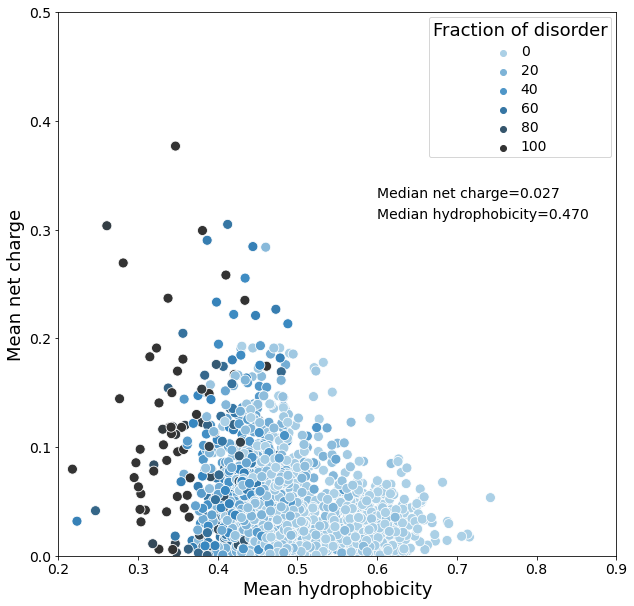

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=BS_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Blues_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = BS_proteome.mean_net_charge.median()
median_hydro = BS_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('BS_proteome_chplot.svg')

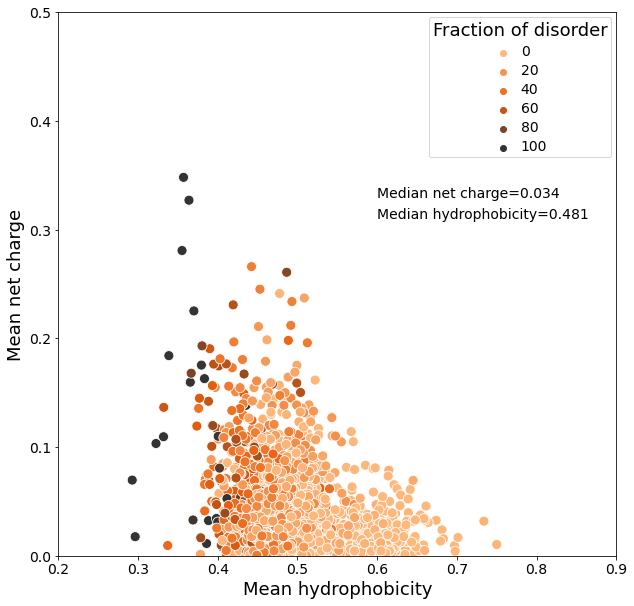

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=MT_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Oranges_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = MT_proteome.mean_net_charge.median()
median_hydro = MT_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('MT_proteome_chplot.svg')

In [ ]:
print('T. thermophilus median hydrophobicity: ' + str(TT_proteome.mean_hydrophobicity.median()))
print('T. thermophilus median charge: ' + str(TT_proteome.mean_net_charge.median()))
print('E. coli median hydrophobicity: ' + str(EC_proteome.mean_hydrophobicity.median()))
print('E. coli median charge: ' + str(EC_proteome.mean_net_charge.median()))
print('B. subtilis median hydrophobicity: ' + str(BS_proteome.mean_hydrophobicity.median()))
print('B. subtilis median charge: ' + str(BS_proteome.mean_net_charge.median()))
print('M. thermoautotrophic median hydrophobicity: ' + str(MT_proteome.mean_hydrophobicity.median()))
print('M. thermoautotrophic median charge: ' + str(MT_proteome.mean_net_charge.median()))

T. thermophilus median hydrophobicity: 0.48915470494417884
T. thermophilus median charge: 0.01760941429428782
E. coli median hydrophobicity: 0.4825268817204295
E. coli median charge: 0.022397669313049016
B. subtilis median hydrophobicity: 0.4701365817644884
B. subtilis median charge: 0.02737501474714723
M. thermoautotrophic median hydrophobicity: 0.4814153439153442
M. thermoautotrophic median charge: 0.03425514376535757
